<a href="https://colab.research.google.com/github/carlogalli/colab-gpu/blob/main/jmp_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

After you run the first cell (the cell directly above this text), go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.7* in Runtime type. You can also select your prefered harwdware acceleration (defaults to GPU).

In [1]:
VERSION   # print Julia version

v"1.7.2"

In [ ]:
using Pkg
Pkg.add(["CUDA", "Random", "Distributions", "Printf", "BenchmarkTools", "PyPlot", "PrettyTables", "PyCall", "Adapt", "DataFrames", "CSV", "GLM", "Optim"]);
ENV["JULIA_CUDA_USE_BINARYBUILDER"] = false
using Random, Distributions, CUDA, Printf, BenchmarkTools, PyPlot, PrettyTables, PyCall, Adapt, DataFrames, CSV, GLM, Optim;

function print_gpu_properties()

    for (i,device) in enumerate(CUDA.devices())
        println("*** General properties for device $i ***")
        name = CUDA.name(device)
        println("Device name: $name")
        major = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MAJOR)
        minor = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MINOR)
        println("Compute capabilities: $major.$minor")
        clock_rate = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_CLOCK_RATE)
        println("Clock rate: $clock_rate")
        device_overlap = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_GPU_OVERLAP)
        print("Device copy overlap: ")
        println(device_overlap > 0 ? "enabled" : "disabled")
        kernel_exec_timeout = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_KERNEL_EXEC_TIMEOUT)
        print("Kernel execution timeout: ")
        println(kernel_exec_timeout > 0 ? "enabled" : "disabled")
        # a = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X)
        # d = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X)       
        a = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT)
        println("Number of multiprocessors: $a")
        b = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_BLOCKS_PER_MULTIPROCESSOR)
        println("Max blocks per MP: $b")
        c = CUDA.attribute(device, CUDA.CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)        
        println("Max threads per block: $c")
        
        println([a b c a*b*c])
    end
end
print_gpu_properties()
# with the falseENV option it takes 117.357304 seconds (35.94 M allocations: 2.301 GiB, 1.29% gc time, 11.71% compilation time)
# without the falseENV option it takes  124.465413 seconds (39.74 M allocations: 2.537 GiB, 1.27% gc time, 12.65% compilation time)


#Pkg.add("CpuId")
#using CpuId
#cpuinfo()

# JMP functions

In [17]:
CUDA.allowscalar(false)

# Model Parameters
struct ModelParams
    # Array Parameters
    nB::Int32
    ny::Int32
    T_longterm::Int32
    T_sim::Int32
    T_discard_sim::Int32
    Bgrid_lb::Float32
    Bgrid_ub::Float32

    # Model Parameters
    σ::Float32      # risk aversion
    η::Float32      # MIU curvature
    r::Float32      # intnl risk-free rate
    ρ::Float32      # income process persistence
    σ_ϵ::Float32    # income process error standard deviation
    θ::Float32      # ree-enter probability
    h::Float32      # haircut on debt
    
    β::Float32      # df govt
    β_hh::Float32   # df hh
    α_m::Float32    # MIU scaling factor
    α_n::Float32    # MIU scaling factor
    d0::Float32     # linear coefficient on default costadd C
    d1::Float32     # quadratic coefficient on default cost
    λ::Float32      # debt maturity
    κ::Float32      # debt coupon
    ρ_B::Float32    # coefficient of Gumbel debt taste shocks
    ρ_μ::Float32    # coefficient of Gumbel mu_D taste shocks
    ρ_δ::Float32    # coefficient of Gumbel enforcement shocks
end
function build_ModelParams(;
        nB=51, ny=21, T_longterm=20, T_sim=10^6, T_discard_sim=10^3, Bgrid_lb=1e-2, Bgrid_ub=2.5,
        σ=2., η=3., r=0.00598, ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37,
        β=.83, β_hh=.99, α_m=1e-5, α_n=0., d0=-0.4, d1=0.43, λ=0.0465, κ=0., 
        ρ_B=1e-3, ρ_μ=1e-3, ρ_δ=1e-3
    )

    return ModelParams(
        nB, ny, T_longterm, T_sim, T_discard_sim, Bgrid_lb, Bgrid_ub,
        σ, η, r, ρ, σ_ϵ, θ, h, 
        β, β_hh, α_m, α_n, d0, d1, λ, κ, 
        ρ_B, ρ_μ, ρ_δ
    )
end

# Model Arrays
struct ModelArrays{V,A}
    Bgrid::V
    ygrid::V
    P::A
    
    v0::A
    v::A
    ev::A
    evd::A
    def_policy::A

    vr::A
    c_rep::A
    rb_rep::A
    Bprime_rep::A
    μ_rep::A
    i_rep::A
    q_rep::A
    qtilde_rep::A
    moneyEulerRHS_rep::A
    bondsEulerRHS_rep::A

    vd::A
    c_def::A
    rb_def::A
    Bprime_def::A
    μ_def::A
    i_def::A
    q_def::A
    qtilde_def::A
    moneyEulerRHS_def::A
    bondsEulerRHS_def::A
end
function build_ModelArrays(mp::ModelParams)
    # Bond grid
    #Bgrid = collect(range(mp.Bgrid_lb, stop=mp.Bgrid_ub, length=mp.nB))
    Bgrid = collect(Float32, [
            range(mp.Bgrid_lb, stop=0.5, length=round(Int32, mp.nB/3));
            range(0.51, stop=mp.Bgrid_ub, length=round(Int32, mp.nB*2/3))
        ])
    Bgrid = CuArray(Bgrid)

    # Endowment grid and transition probs
    grid, P = tauchen_carlo(mp.ny, mp.ρ, mp.σ_ϵ)
    ygrid = CuArray(exp.(grid))
    P = CuArray(P)
    
    v0, v, ev, evd, def_policy = [CUDA.zeros(mp.nB, mp.ny) for i in 1:5]
    vr, c_rep, rb_rep, Bprime_rep, μ_rep, i_rep, q_rep, qtilde_rep, moneyEulerRHS_rep, bondsEulerRHS_rep = [CUDA.zeros(mp.nB, mp.ny) for i in 1:10]
    vd, c_def, rb_def, Bprime_def, μ_def, i_def, q_def, qtilde_def, moneyEulerRHS_def, bondsEulerRHS_def = [CUDA.zeros(mp.nB, mp.ny) for i in 1:10]

    return ModelArrays(
        Bgrid, ygrid, P,
        v0, v, ev, evd, def_policy,
        vr, c_rep, rb_rep, Bprime_rep, μ_rep, i_rep, q_rep, qtilde_rep, moneyEulerRHS_rep, bondsEulerRHS_rep,
        vd, c_def, rb_def, Bprime_def, μ_def, i_def, q_def, qtilde_def, moneyEulerRHS_def, bondsEulerRHS_def
    )
end
function Adapt.adapt_structure(to, model::ModelArrays)
    Bgrid = Adapt.adapt_structure(to, model.Bgrid)
    ygrid = Adapt.adapt_structure(to, model.ygrid)
    P = Adapt.adapt_structure(to, model.P)
    v0 = Adapt.adapt_structure(to, model.v0)
    v = Adapt.adapt_structure(to, model.v)
    ev = Adapt.adapt_structure(to, model.ev)
    evd = Adapt.adapt_structure(to, model.evd)
    def_policy = Adapt.adapt_structure(to, model.def_policy)
    vr = Adapt.adapt_structure(to, model.vr)
    c_rep = Adapt.adapt_structure(to, model.c_rep)
    rb_rep = Adapt.adapt_structure(to, model.rb_rep)
    Bprime_rep = Adapt.adapt_structure(to, model.Bprime_rep)
    μ_rep = Adapt.adapt_structure(to, model.μ_rep)
    i_rep = Adapt.adapt_structure(to, model.i_rep)
    q_rep = Adapt.adapt_structure(to, model.q_rep)
    qtilde_rep = Adapt.adapt_structure(to, model.qtilde_rep)
    moneyEulerRHS_rep = Adapt.adapt_structure(to, model.moneyEulerRHS_rep)
    bondsEulerRHS_rep = Adapt.adapt_structure(to, model.bondsEulerRHS_rep)
    vd = Adapt.adapt_structure(to, model.vd)
    c_def = Adapt.adapt_structure(to, model.c_def)
    rb_def = Adapt.adapt_structure(to, model.rb_def)
    Bprime_def = Adapt.adapt_structure(to, model.Bprime_def)
    μ_def = Adapt.adapt_structure(to, model.μ_def)
    i_def = Adapt.adapt_structure(to, model.i_def)
    q_def = Adapt.adapt_structure(to, model.q_def)
    qtilde_def = Adapt.adapt_structure(to, model.qtilde_def)
    moneyEulerRHS_def = Adapt.adapt_structure(to, model.moneyEulerRHS_def)
    bondsEulerRHS_def = Adapt.adapt_structure(to, model.bondsEulerRHS_def)

    ModelArrays(
        Bgrid, ygrid, P,
        v0, v, ev, evd, def_policy,
        vr, c_rep, rb_rep, Bprime_rep, μ_rep, i_rep, q_rep, qtilde_rep, moneyEulerRHS_rep, bondsEulerRHS_rep,
        vd, c_def, rb_def, Bprime_def, μ_def, i_def, q_def, qtilde_def, moneyEulerRHS_def, bondsEulerRHS_def,
    )
end

# Model Arrays (temporary)
struct ModelArraysTemp{A}
    vs_rep::A
    cs_rep::A
    rbs_rep::A
    cps_rep::A
    vs_def::A
    cps_def::A
end
function build_ModelArraysTemp(mp::ModelParams)
    vs_rep, cs_rep, rbs_rep, cps_rep, vs_def, cps_def = [CUDA.zeros(mp.nB, mp.ny, mp.nB) for i in 1:6]

    return ModelArraysTemp(
        vs_rep, cs_rep, rbs_rep, cps_rep, vs_def, cps_def
    )
end
function Adapt.adapt_structure(to, model::ModelArraysTemp)
    vs_rep = Adapt.adapt_structure(to, model.vs_rep)
    cs_rep = Adapt.adapt_structure(to, model.cs_rep)
    rbs_rep = Adapt.adapt_structure(to, model.rbs_rep)
    cps_rep = Adapt.adapt_structure(to, model.cps_rep)
    vs_def = Adapt.adapt_structure(to, model.vs_def)
    cps_def = Adapt.adapt_structure(to, model.cps_def)

    ModelArraysTemp(
        vs_rep, cs_rep, rbs_rep, cps_rep, vs_def, cps_def
    )
end

# Equilibrium Prices
struct PricesEqm{A}
    expdef_short_eqm_rep::A
    expdef_long_eqm_rep::A
    expinf_short_eqm_rep::A
    expinf_long_eqm_rep::A
    expinf_long_eqm_def::A
end
function build_PricesEqm(mp::ModelParams)
    expdef_short_eqm_rep, expdef_long_eqm_rep = [CUDA.zeros(Float32, mp.nB, mp.ny) for i in 1:2]
    expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def = [CUDA.ones(Float32, mp.nB, mp.ny) for i in 1:3]

    return PricesEqm(
        expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def
    )
end
function Adapt.adapt_structure(to, model::PricesEqm)
    expdef_short_eqm_rep = Adapt.adapt_structure(to, model.expdef_short_eqm_rep)
    expdef_long_eqm_rep = Adapt.adapt_structure(to, model.expdef_long_eqm_rep)
    expinf_short_eqm_rep = Adapt.adapt_structure(to, model.expinf_short_eqm_rep)
    expinf_long_eqm_rep = Adapt.adapt_structure(to, model.expinf_long_eqm_rep)
    expinf_long_eqm_def = Adapt.adapt_structure(to, model.expinf_long_eqm_def)

    PricesEqm(
        expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def
    )
end

# Future Prices
struct PricesFuture{A}
    expdef_short_future_rep::A
    expdef_long_future_rep::A
    expinf_short_future_rep::A
    expinf_long_future_rep::A
    expinf_long_future_def::A
end
function build_PricesFuture(mp::ModelParams)
    expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def = [CUDA.zeros(Float32, mp.nB, mp.ny) for i in 1:5]

    return PricesFuture(
        expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def
    )
end
function Adapt.adapt_structure(to, model::PricesFuture)
    expdef_short_future_rep = Adapt.adapt_structure(to, model.expdef_short_future_rep)
    expdef_long_future_rep = Adapt.adapt_structure(to, model.expdef_long_future_rep)
    expinf_short_future_rep = Adapt.adapt_structure(to, model.expinf_short_future_rep)
    expinf_long_future_rep = Adapt.adapt_structure(to, model.expinf_long_future_rep)
    expinf_long_future_def = Adapt.adapt_structure(to, model.expinf_long_future_def)

    PricesFuture(
        expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def
    )
end

# Simulation Arrays
struct SimulationArrays{Vfloat, Vbool, Vint}
    y_sim::Vfloat
    B_sim::Vfloat
    q_sim::Vfloat
    rb_sim::Vfloat
    μ_qoq_sim::Vfloat
    μ_yoy_sim::Vfloat
    def_status::Vbool
    def_new::Vbool
    inf_qoq_sim::Vfloat
    inf_yoy_sim::Vfloat
    c_sim::Vfloat
    i_sim::Vfloat
    B_sim_indices::Vint
    y_sim_indices::Vint
    taste_errors::Vfloat
end
function build_SimulationArrays(mp::ModelParams)
    y_sim, B_sim, q_sim, rb_sim, μ_qoq_sim, inf_qoq_sim, c_sim, i_sim = [zeros(Float32, mp.T_sim) for i in 1:8]
    μ_yoy_sim, inf_yoy_sim = [ones(Float32, mp.T_sim) for i in 1:8]
    def_status, def_new = [zeros(Bool, mp.T_sim) for i in 1:2]
    B_sim_indices, y_sim_indices = [zeros(Int32, mp.T_sim) for i in 1:2]
    taste_errors = zeros(Float32, 3)

    return SimulationArrays(
        y_sim, B_sim, q_sim, rb_sim, μ_qoq_sim, μ_yoy_sim, def_status, def_new, inf_qoq_sim, inf_yoy_sim, c_sim, i_sim, B_sim_indices, y_sim_indices, taste_errors
    )
end
function Adapt.adapt_structure(to, model::SimulationArrays)
    y_sim = Adapt.adapt_structure(to, model.y_sim)
    B_sim = Adapt.adapt_structure(to, model.B_sim)
    q_sim = Adapt.adapt_structure(to, model.q_sim)
    rb_sim = Adapt.adapt_structure(to, model.rb_sim)
    μ_qoq_sim = Adapt.adapt_structure(to, model.μ_qoq_sim)
    μ_yoy_sim = Adapt.adapt_structure(to, model.μ_yoy_sim)
    def_status = Adapt.adapt_structure(to, model.def_status)
    def_new = Adapt.adapt_structure(to, model.def_new)
    inf_qoq_sim = Adapt.adapt_structure(to, model.inf_qoq_sim)
    inf_yoy_sim = Adapt.adapt_structure(to, model.inf_yoy_sim)
    c_sim = Adapt.adapt_structure(to, model.c_sim)
    i_sim = Adapt.adapt_structure(to, model.i_sim)
    B_sim_indices = Adapt.adapt_structure(to, model.B_sim_indices)
    y_sim_indices = Adapt.adapt_structure(to, model.y_sim_indices)
    taste_errors = Adapt.adapt_structure(to, model.taste_errors)

    SimulationArrays(
        y_sim, B_sim, q_sim, rb_sim, μ_qoq_sim, μ_yoy_sim, def_status, def_new, inf_qoq_sim, inf_yoy_sim, c_sim, i_sim, B_sim_indices, y_sim_indices, taste_errors
    )
end

# Simulation Prices
struct SimulationPrices{V}
    expdef_short_sim::V
    expdef_long_sim::V
    expinf_short_sim::V
    expinf_long_sim::V
end
function build_SimulationPrices(mp::ModelParams)
    expdef_short_sim, expdef_long_sim, expinf_short_sim, expinf_long_sim = [zeros(Float32, mp.T_sim) for i in 1:4]

    return SimulationPrices(
        expdef_short_sim, expdef_long_sim, expinf_short_sim, expinf_long_sim
    )
end
function Adapt.adapt_structure(to, model::SimulationPrices)
    expdef_short_sim = Adapt.adapt_structure(to, model.expdef_short_sim)
    expdef_long_sim = Adapt.adapt_structure(to, model.expdef_long_sim)
    expinf_short_sim = Adapt.adapt_structure(to, model.expinf_short_sim)
    expinf_long_sim = Adapt.adapt_structure(to, model.expinf_long_sim)

    SimulationPrices(
        expdef_short_sim, expdef_long_sim, expinf_short_sim, expinf_long_sim
    )
end

# Functions
function tauchen_carlo(N::Int32, ρ::Float32, σ_ϵ::Float32; μ::Real=0, n_std::Real=4)

    # process (x_t above) standard deviation (std is ϵ's standard deviation)
    σ_y = σ_ϵ/sqrt(1-ρ^2)
    grid_bar = n_std * σ_y      # grid bounds
    grid = collect(Float32, range(μ-grid_bar, stop=μ+grid_bar, length=N))
    dif = grid[2]-grid[1]
  
    # Get transition probabilities
    P = zeros(Float32, N, N)
    
    # return nothing

    for row in 1:N
        
        # do endpoints first
        P[row, 1] = cdf(Normal(0., 1.), (grid[1]+dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ )
        P[row, N] = 1-cdf(Normal(0., 1.), (grid[N]-dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ )

        # middle columns
        for col in 2:N-1
            P[row, col] = cdf(Normal(0., 1.), (grid[col]+dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ ) - cdf(Normal(0., 1.), (grid[col]-dif/2 -(1-ρ)*μ -ρ*grid[row])/σ_ϵ )
        end
    end

    # normalize
    sums = sum(P, dims=2)    

    P = @. P/sums
    
    if maximum(abs.(sum(P, dims=2).-1)) > 1e-6
        error("Matrix rows must sum up to 1!")
    end
  
    return grid, P
end

function ydef_fn(mp::ModelParams, y::Float32)
    return y - max(0, mp.d0*y + mp.d1*y^2)
end

function my_dot_product(xvec, yvec)
    temp = Float32(0)
    for i in 1:lastindex(xvec)
        temp += xvec[i]*yvec[i]
    end
    return temp
end

function my_brent(
    f::Function , x_lower::Float32, x_upper::Float32;
    rel_tol::Float32 = sqrt(eps(Float32)),
    abs_tol::Float32 = eps(Float32),
    iterations::Int32 = Int32(1000),
    my_trace::Bool = false)


    if x_lower > x_upper
        error("x_lower must be less than x_upper")
    end

    golden_ratio = Float32(1)/2 * (3 - sqrt(Float32(5.0)))

    new_minimizer = x_lower + golden_ratio*(x_upper-x_lower)
    new_minimum = f(new_minimizer)
    best_bound = "initial"
    f_calls = 1 # Number of calls to f
    step = zero(Float32)
    old_step = zero(Float32)

    old_minimizer = new_minimizer
    old_old_minimizer = new_minimizer

    old_minimum = new_minimum
    old_old_minimum = new_minimum

    iteration = 0
    converged = false
    stopped_by_callback = false

    while iteration < iterations && !stopped_by_callback

        p = zero(Float32)
        q = zero(Float32)

        x_tol = rel_tol * abs(new_minimizer) + abs_tol

        x_midpoint = (x_upper+x_lower)/2

        if abs(new_minimizer - x_midpoint) <= 2*x_tol - (x_upper-x_lower)/2
            converged = true
            break
        end

        iteration += 1

        if abs(old_step) > x_tol
            # Compute parabola interpolation
            # new_minimizer + p/q is the optimum of the parabola
            # Also, q is guaranteed to be positive

            r = (new_minimizer - old_minimizer) * (new_minimum - old_old_minimum)
            q = (new_minimizer - old_old_minimizer) * (new_minimum - old_minimum)
            p = (new_minimizer - old_old_minimizer) * q - (new_minimizer - old_minimizer) * r
            q = 2(q - r)

            if q > 0
                p = -p
            else
                q = -q
            end
        end

        if abs(p) < abs(q*old_step/2) && p < q*(x_upper-new_minimizer) && p < q*(new_minimizer-x_lower)
            old_step = step
            step = p/q

            # The function must not be evaluated too close to x_upper or x_lower
            x_temp = new_minimizer + step
            if ((x_temp - x_lower) < 2*x_tol || (x_upper - x_temp) < 2*x_tol)
                step = (new_minimizer < x_midpoint) ? x_tol : -x_tol
            end
        else
            old_step = (new_minimizer < x_midpoint) ? x_upper - new_minimizer : x_lower - new_minimizer
            step = golden_ratio * old_step
        end

        # The function must not be evaluated too close to new_minimizer
        if abs(step) >= x_tol
            new_x = new_minimizer + step
        else
            new_x = new_minimizer + ((step > 0) ? x_tol : -x_tol)
        end

        new_f = f(new_x)
        f_calls += 1

        if new_f < new_minimum
            if new_x < new_minimizer
                x_upper = new_minimizer
                best_bound = "upper"
            else
                x_lower = new_minimizer
                best_bound = "lower"
            end
            old_old_minimizer = old_minimizer
            old_old_minimum = old_minimum
            old_minimizer = new_minimizer
            old_minimum = new_minimum
            new_minimizer = new_x
            new_minimum = new_f
        else
            if new_x < new_minimizer
                x_lower = new_x
            else
                x_upper = new_x
            end
            if new_f <= old_minimum || old_minimizer == new_minimizer
                old_old_minimizer = old_minimizer
                old_old_minimum = old_minimum
                old_minimizer = new_x
                old_minimum = new_f
            elseif new_f <= old_old_minimum || old_old_minimizer == new_minimizer || old_old_minimizer == old_minimizer
                old_old_minimizer = new_x
                old_old_minimum = new_f
            end
        end
    end

    if my_trace
        out = iteration, iteration == iterations, converged, rel_tol, abs_tol, f_calls
        return new_minimizer, new_minimum, out
    else
        return new_minimizer, new_minimum
    end
end

u_gov_fn(mp::ModelParams, c, rb) = (c^(1-mp.σ))/(1-mp.σ) + (mp.α_m+mp.α_n)*(rb^(1-mp.η))/(1-mp.η)
uc_gov_fn(mp::ModelParams, c) = c^(-mp.σ)
um_gov_fn(mp::ModelParams, rb) = (mp.α_m+mp.α_n)*rb^(-mp.η)
uc_hh_fn(mp::ModelParams, c) = c^(-mp.σ)
um_hh_fn(mp::ModelParams, rb) = (mp.α_m)*rb^(-mp.η)

function model_init!(mp::ModelParams, ma::ModelArrays)


    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
    # tid_x, tid_y, bid_x, bid_y = threadIdx().x, threadIdx().y, blockIdx().x, blockIdx().y
    # @cuprintln("y0 $y0, B0 $B0, tid_x $tid_x, tid_y $tid_y, bid_x $bid_x, bid_y $bid_y")

    if B0 <= mp.nB && y0 <= mp.ny
        #= Repayment: in the last period, max U(c,rb,g) s.t. c=y-̃B*rb =#
        ma.rb_rep[B0,y0] = 0.5 * ma.ygrid[y0]/ma.Bgrid[B0]
        ma.c_rep[B0,y0] = ma.ygrid[y0]-ma.Bgrid[B0]*ma.rb_rep[B0,y0]
        #ma.vr[B0,y0] = (ma.c_rep[B0,y0]^(1-mp.σ))/(1-mp.σ) + (mp.α_m+mp.α_n)*(ma.rb_rep[B0,y0]^(1-mp.η))/(1-mp.η)
        ma.vr[B0,y0] = u_gov_fn(mp, ma.c_rep[B0,y0], ma.rb_rep[B0,y0])
        ma.Bprime_rep[B0,y0] = 0.
        ma.q_rep[B0, y0] = 1.
        
        #= Default: in the last period, max U(c,rb,g) s.t. c=y_def-̃B*(1-h)*rb =#
        yd = ydef_fn(mp, ma.ygrid[y0])
        ma.rb_def[B0,y0] = 0.5*yd/(ma.Bgrid[B0]*(1-mp.h))
        ma.c_def[B0,y0] = yd-ma.Bgrid[B0]*(1-mp.h)*ma.rb_def[B0,y0]
        #ma.vd[B0,y0] = (ma.c_def[B0,y0]^(1-mp.σ))/(1-mp.σ) + (mp.α_m+mp.α_n)*(ma.rb_def[B0,y0]^(1-mp.η))/(1-mp.η)
        ma.vd[B0,y0] = u_gov_fn(mp, ma.c_def[B0,y0], ma.rb_def[B0,y0])
        ma.Bprime_def[B0,y0] = 0.
        ma.μ_def[B0,y0] = 0.
        ma.q_def[B0, y0] = 1.
    end

    return nothing
end

function update_values_expectations_1!(mp::ModelParams, ma::ModelArrays)
    """
        update_values_expectations_1!()
        uses: m, vr, vd
        updates: def_policy, v
    """

    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if B0 <= mp.nB && y0 <= mp.ny

        if exp((ma.vd[B0,y0]-ma.vr[B0,y0])/mp.ρ_δ) == Inf
            ma.def_policy[B0,y0] = 1.
        else
            ma.def_policy[B0,y0] = exp((ma.vd[B0,y0]-ma.vr[B0,y0])/mp.ρ_δ) / (1+exp((ma.vd[B0,y0]-ma.vr[B0,y0])/mp.ρ_δ))
        end    
        ma.v[B0,y0] = ma.def_policy[B0,y0]*ma.vd[B0,y0] + (1-ma.def_policy[B0,y0])*ma.vr[B0,y0]
    end

    return nothing
end

function update_values_expectations_2!(mp::ModelParams, ma::ModelArrays)

    """
        update_values_expectations_2!()
        uses: m, Bgrid, v, vd, P, def_policy, c_rep, rb_rep, q_rep, c_def, rb_def, q_def
        updates: ev, evd, qtilde_rep, qtilde_def, moneyEulerRHS_rep, moneyEulerRHS_def, bondsEulerRHS_rep, bondsEulerRHS_def
    """

    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if B0 <= mp.nB && y0 <= mp.ny

        B1 = B0
        B1_def = B1     # to keep things clearer when computing qtilde_def
        B1_def_hc = CUDA.min(CUDA.searchsortedfirst(ma.Bgrid, ma.Bgrid[B1_def]*(1-mp.h)), mp.nB)

        # Reset values to zero
        ma.ev[B1, y0], ma.evd[B1, y0] = 0., 0.
        ma.qtilde_rep[B1, y0], ma.qtilde_def[B1, y0] = 0., 0.
        ma.moneyEulerRHS_rep[B1, y0], ma.moneyEulerRHS_def[B1, y0] = 0., 0.
        ma.bondsEulerRHS_rep[B1, y0], ma.bondsEulerRHS_def[B1, y0] = 0., 0.

        for y1 in 1:mp.ny

            # compute expected value functions, makes them functions of (̃B',y)
            ma.ev[B1, y0] += ma.v[B1, y1] * ma.P[y0, y1]
            ma.evd[B1, y0] += ma.vd[B1, y1] * ma.P[y0, y1]

            #= 
            the update of the qtilde price fns should only use q_rep and q_def, not qtilde's 
            =#

            # uses: def_policy, q_rep, rb_rep, q_def, rb_def
            ma.qtilde_rep[B1,y0] += (
                (1-ma.def_policy[B1,y1])*(mp.λ+(1-mp.λ)*(mp.κ+ma.q_rep[B1,y1]))*ma.rb_rep[B1,y1] + ma.def_policy[B1,y1]*ma.q_def[B1,y1]*ma.rb_def[B1,y1]
            ) * ma.P[y0,y1]
        
            # uses: q_def, rb_def here, q_rep, rb_rep below
            ma.qtilde_def[B1_def, y0] += (
                (1-mp.θ)*ma.q_def[B1_def,y1]*ma.rb_def[B1_def,y1] + 
                mp.θ*(1-mp.h)*(
                    (1-ma.def_policy[B1_def_hc,y1])*(mp.λ+(1-mp.λ)*(mp.κ+ma.q_rep[B1_def_hc,y1]))*ma.rb_rep[B1_def_hc,y1] 
                    + ma.def_policy[B1_def_hc,y1]*ma.q_def[B1_def_hc,y1]*ma.rb_def[B1_def_hc,y1]
                )
            ) * ma.P[y0,y1]

            # uses: def_policy, c_rep, rb_rep, c_def, rb_def
            ma.moneyEulerRHS_rep[B1, y0] += mp.β_hh * (
                    (1-ma.def_policy[B1,y1])*(uc_hh_fn(mp, ma.c_rep[B1,y1]) + um_hh_fn(mp, ma.rb_rep[B1,y1]))*ma.rb_rep[B1,y1] + 
                    ma.def_policy[B1,y1]*(uc_hh_fn(mp, ma.c_def[B1,y1]) + um_hh_fn(mp, ma.rb_def[B1,y1]))*ma.rb_def[B1,y1]
                ) * ma.P[y0,y1]

            # uses: def_policy, c_rep, rb_rep, c_def, rb_def
            ma.moneyEulerRHS_def[B1, y0] += mp.β_hh * (
                    (1-mp.θ)*(uc_hh_fn(mp, ma.c_def[B1,y1]) + um_hh_fn(mp, ma.rb_def[B1,y1]))*ma.rb_def[B1,y1] + 
                    mp.θ*(1-ma.def_policy[B1_def_hc,y1])*(uc_hh_fn(mp, ma.c_rep[B1_def_hc,y1]) + um_hh_fn(mp, ma.rb_rep[B1_def_hc,y1]))*ma.rb_rep[B1_def_hc,y1] + 
                    mp.θ*ma.def_policy[B1_def_hc,y1]*(uc_hh_fn(mp, ma.c_def[B1_def_hc,y1]) + um_hh_fn(mp, ma.rb_def[B1_def_hc,y1]))*ma.rb_def[B1_def_hc,y1]
                ) * ma.P[y0,y1]

            # uses: def_policy, c_rep, rb_rep, c_def, rb_def
            ma.bondsEulerRHS_rep[B1, y0] += mp.β_hh * (
                    (1-ma.def_policy[B1,y1])*uc_hh_fn(mp, ma.c_rep[B1,y1])*ma.rb_rep[B1,y1] + 
                    ma.def_policy[B1,y1]*uc_hh_fn(mp, ma.c_def[B1,y1])*ma.rb_def[B1,y1]
                ) * ma.P[y0,y1]

            # uses: def_policy, c_rep, rb_rep, c_def, rb_def
            ma.bondsEulerRHS_def[B1, y0] += mp.β_hh * (
                    (1-mp.θ)*uc_hh_fn(mp, ma.c_def[B1,y1])*ma.rb_def[B1,y1] + 
                    mp.θ*(1-ma.def_policy[B1_def_hc,y1])*uc_hh_fn(mp, ma.c_rep[B1_def_hc,y1])*ma.rb_rep[B1_def_hc,y1] + 
                    mp.θ*ma.def_policy[B1_def_hc,y1]*uc_hh_fn(mp, ma.c_def[B1_def_hc,y1])*ma.rb_def[B1_def_hc,y1]
                ) * ma.P[y0,y1]
        end
    end

    return nothing
end

function vr_gridsearch(mp::ModelParams, ma::ModelArrays, mat::ModelArraysTemp)
    
    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if B0 <= mp.nB && y0 <= mp.ny

        #y0s[B0,y0]=y0
        #B0s[B0,y0]=B0
        vstar = Float32(-Inf)

        for B1 in 1:mp.nB
            c_lb = Float32(1e-4)
            c_ub = ma.ygrid[y0] + ma.qtilde_rep[B1, y0]*ma.Bgrid[B1]

            #c, ~ = my_brent(
            #            c -> - u_gov_fn(
            #                    mp, c, (ma.ygrid[y0]+ma.qtilde_rep[B1,y0]*ma.Bgrid[B1]-c) / 
            #                    (ma.Bgrid[B0]*(mp.λ+(1-mp.λ)*mp.κ + ma.qtilde_rep[B1,y0]*(1-mp.λ)*c^(-mp.σ)/(mp.β_hh*ma.moneyEulerRHS_rep[B1, y0])))
            #                ),
            #            c_lb, c_ub)
            #rb = (ma.ygrid[y0]+ma.qtilde_rep[B1,y0]*ma.Bgrid[B1]-c)/(ma.Bgrid[B0]*(mp.λ+(1-mp.λ)*mp.κ + ma.qtilde_rep[B1,y0]*(1-mp.λ)*c^(-mp.σ)/(mp.β_hh*ma.moneyEulerRHS_rep[B1, y0])))

            rb = 1.
            c = ma.ygrid[y0]+ma.qtilde_rep[B1,y0]*(ma.Bgrid[B1]-ma.Bgrid[B0]*(1-mp.λ)) -
                ma.Bgrid[B0]*(mp.λ+(1-mp.λ)*mp.κ)

            mat.cs_rep[B0,y0,B1] = c
            mat.rbs_rep[B0,y0,B1] = rb

            v = u_gov_fn(mp, c, rb) + mp.β * ma.ev[B1, y0]
            mat.vs_rep[B0,y0,B1] = v
            vstar = ifelse(v>vstar, v, vstar)
        end
        
        D = 0.
        for B1 in 1:mp.nB
            D += exp((mat.vs_rep[B0,y0,B1]-vstar)/mp.ρ_B)
        end
        for B1 in 1:mp.nB
            mat.cps_rep[B0,y0,B1] = exp((mat.vs_rep[B0,y0,B1]-vstar)/mp.ρ_B)/D
        end
        
        ma.vr[B0,y0] = vstar + mp.ρ_B*log(D)

        ma.c_rep[B0,y0], ma.rb_rep[B0,y0], ma.Bprime_rep[B0,y0], ma.q_rep[B0,y0], ma.i_rep[B0,y0], ma.μ_rep[B0,y0] = 0., 0., 0., 0., 0., 0.
        for B1 in 1:mp.nB
            cp = mat.cps_rep[B0,y0,B1]
            
            c = mat.cs_rep[B0,y0,B1]
            rb = mat.rbs_rep[B0,y0,B1]
            ucprime = uc_gov_fn(mp, c)
            μ = 0.
            
            ma.c_rep[B0,y0] += cp * c
            ma.rb_rep[B0,y0] += cp * rb
            ma.q_rep[B0,y0] += cp * ma.qtilde_rep[B1, y0] / (rb*(1+μ)*(1+mp.r))
            
            # all of these things are not necessary for VFI and so can be computed only at the end
            ma.Bprime_rep[B0,y0] += cp * ma.Bgrid[B1]
            ma.i_rep[B0,y0] += cp * (((1+μ)*rb*ucprime) / ma.bondsEulerRHS_rep[B1, y0] -1)
            ma.μ_rep[B0,y0] += cp * μ
        end
    end

    return nothing
end

function vd_gridsearch(mp::ModelParams, ma::ModelArrays, mat::ModelArraysTemp)
    
    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
    
    if B0 <= mp.nB && y0 <= mp.ny

        #y0s[B0,y0]=y0
        #B0s[B0,y0]=B0
        vstar = Float32(-Inf)

        for B1_def in 1:mp.nB
            
            c = ydef_fn(mp, ma.ygrid[y0])
            μ = 0.
            ucprime = uc_gov_fn(mp, c)
            rb = 1.
            B1_def_hc = min(searchsortedfirst(ma.Bgrid, ma.Bgrid[B1_def]*(1-mp.h)), mp.nB)
            
            v = u_gov_fn(mp, c, rb) + mp.β * (
                    (1-mp.θ)*ma.evd[B1_def, y0] + mp.θ*ma.ev[B1_def_hc, y0]
                )
            mat.vs_def[B0,y0,B1_def] = v

            vstar = ifelse(v>vstar, v, vstar)
        end
  
        D = 0.
        for B1_def in 1:mp.nB
            D += exp((mat.vs_def[B0,y0,B1_def]-vstar)/mp.ρ_μ)
        end
        for B1_def in 1:mp.nB
            mat.cps_def[B0,y0,B1_def] = exp((mat.vs_def[B0,y0,B1_def]-vstar)/mp.ρ_μ) / D
        end
        
        ma.vd[B0,y0] = vstar + mp.ρ_μ*log(D)
        ma.c_def[B0,y0] = ydef_fn(mp, ma.ygrid[y0])

        ma.rb_def[B0,y0], ma.Bprime_def[B0,y0], ma.q_def[B0,y0], ma.i_def[B0,y0], ma.μ_def[B0,y0] = 0., 0., 0., 0., 0.
        
        for B1_def in 1:mp.nB
            cp = mat.cps_def[B0,y0,B1_def]
            
            μ = 0.
            rb = 1.
            ucprime = ma.c_def[B0,y0]^(-mp.σ)
            
            ma.μ_def[B0,y0] += cp * μ
            ma.rb_def[B0,y0] += cp * rb
            ma.Bprime_def[B0,y0] += cp * ma.Bgrid[B1_def]
            ma.q_def[B0,y0] += cp * ma.qtilde_def[B1_def, y0] / (rb*(1+μ)*(1+mp.r))
            ma.i_def[B0,y0] += cp * (((1+μ)*rb*ucprime) / ma.bondsEulerRHS_def[B1_def, y0] -1)
            
        end
    end

    return nothing
end

function compute_prices_future!(mp::ModelParams, ma::ModelArrays, pe::PricesEqm, pf::PricesFuture)
    """
        compute_prices_future!()
        uses: 
        - P, def_policy, rb_rep, rb_def
        - expdef_long_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def
        updates: 
        - expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep
    """
    # Uses eqm prices to compute future prices (that depends on (B',y))
    
    # Perform computations
    B1 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if B1 <= mp.nB && y0 <= mp.ny
        B1_def = B1     # to keep things clearer when computing qtilde_def
        B1_def_hc = CUDA.min(CUDA.searchsortedfirst(ma.Bgrid, ma.Bgrid[B1_def]*(1-mp.h)), mp.nB)

        pf.expdef_short_future_rep[B1,y0], pf.expdef_long_future_rep[B1,y0], pf.expinf_short_future_rep[B1,y0], pf.expinf_long_future_rep[B1,y0], pf.expinf_long_future_def[B1_def,y0] = 0., 0., 0., 0., 0.
        
        for y1 in 1:mp.ny
            pf.expdef_short_future_rep[B1,y0] += (
                ma.def_policy[B1,y1]
            ) * ma.P[y0,y1]
            
            pf.expdef_long_future_rep[B1,y0] += (
                ma.def_policy[B1,y1] + (1-ma.def_policy[B1,y1])*pe.expdef_long_eqm_rep[B1,y1]
            ) * ma.P[y0,y1]
            
            # E[ 1/m_t+1(B_t+1, y_t+1) | y_t ]      GROSS inflation!!!
            pf.expinf_short_future_rep[B1,y0] += (
                (1-ma.def_policy[B1,y1]) * 1/ma.rb_rep[B1,y1] + ma.def_policy[B1,y1] * 1/ma.rb_def[B1,y1]
            ) * ma.P[y0,y1]
            
            # E[ XCS^eqm_t+1(B_t+1, y_t+1) / m_t+1(B_t+1, y_t+1) | y_t ]    GROSS inflation!!!
            pf.expinf_long_future_rep[B1,y0] += (
                (1-ma.def_policy[B1,y1]) * pe.expinf_long_eqm_rep[B1,y1]/ma.rb_rep[B1,y1] + ma.def_policy[B1,y1] * pe.expinf_long_eqm_def[B1,y1]/ma.rb_def[B1,y1]
            ) * ma.P[y0,y1]

            pf.expinf_long_future_def[B1_def,y0] += (
                (1-mp.θ) * pe.expinf_long_eqm_def[B1_def,y1]/ma.rb_def[B1_def,y1]
                + mp.θ*(1-ma.def_policy[B1_def_hc,y1]) * pe.expinf_long_eqm_rep[B1_def_hc,y1]/ma.rb_rep[B1_def_hc,y1] 
                + mp.θ*ma.def_policy[B1_def_hc,y1] * pe.expinf_long_eqm_def[B1_def_hc,y1]/ma.rb_def[B1_def_hc,y1]
            ) * ma.P[y0,y1]
        end
    end
    return nothing
end

function compute_prices_eqm!(mp::ModelParams, ma::ModelArrays, mat::ModelArraysTemp, pe::PricesEqm, pf::PricesFuture)
    """
        compute_prices_eqm!()
        uses: 
        - def_policy, cps_rep, rbs_rep, cs_rep, cps_def
        - expdef_short_future_rep, expdef_long_future_rep, expinf_short_future_rep, expinf_long_future_rep, expinf_long_future_def
        updates: 
        - expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def
    """

    # Perform computations
    B0 = (blockIdx().x-1)*blockDim().x + threadIdx().x
    y0 = (blockIdx().y-1)*blockDim().y + threadIdx().y
    
    if B0 <= mp.nB && y0 <= mp.ny
        c_def = ydef_fn(mp, ma.ygrid[y0])

        pe.expdef_short_eqm_rep[B0,y0], pe.expdef_long_eqm_rep[B0,y0], pe.expinf_short_eqm_rep[B0,y0], pe.expinf_long_eqm_rep[B0,y0], pe.expinf_long_eqm_def[B0,y0] = 0., 0., 0., 0., 0.
        
        for B1 in 1:mp.nB

            pe.expdef_short_eqm_rep[B0,y0] += mat.cps_rep[B0,y0,B1] * pf.expdef_short_future_rep[B1,y0]
            pe.expdef_long_eqm_rep[B0,y0] += mat.cps_rep[B0,y0,B1] * pf.expdef_long_future_rep[B1,y0]
                
            rb_rep = mat.rbs_rep[B0,y0,B1]
            c_rep = mat.cs_rep[B0,y0,B1]
            μ_rep = ma.moneyEulerRHS_rep[B1,y0] / (rb_rep * uc_gov_fn(mp, c_rep)) - 1
            
            pe.expinf_short_eqm_rep[B0,y0] += mat.cps_rep[B0,y0,B1] * rb_rep * (1+μ_rep) * pf.expinf_short_future_rep[B1,y0]
            pe.expinf_long_eqm_rep[B0,y0] += mat.cps_rep[B0,y0,B1] * rb_rep * (1+μ_rep) * pf.expinf_long_future_rep[B1,y0]

            B1_def = B1
            μ_def = ma.Bgrid[B0]/ma.Bgrid[B1_def]-1
            rb_def = ma.moneyEulerRHS_def[B1_def, y0] / (uc_gov_fn(mp, c_def) * (1+μ_def))

            pe.expinf_long_eqm_def[B0,y0] += mat.cps_def[B0,y0,B1_def] * rb_def * (1+μ_def) * pf.expinf_long_future_def[B1_def,y0]
        end
    end
    return nothing
end

function main_gpu(mp::ModelParams; max_iter::Int=1000, print_iter::Int=0, plot::Int=0, ret_arrays::Bool=false, sim_print::String="no")

    # Define GPU threads and blocks
    threadsize = 16
    ts = (threadsize, threadsize)
    blocksize = cld(mp.nB, threadsize)
    bs = (blocksize, blocksize)

    # Create ModelArrays object
    ma = build_ModelArrays(mp)
    mat = build_ModelArraysTemp(mp)

    # Initialise everything
    @cuda threads=ts blocks=bs model_init!(mp, ma)    
    @cuda threads=ts blocks=bs update_values_expectations_1!(mp, ma)
    @cuda threads=ts blocks=bs update_values_expectations_2!(mp, ma)

    # Iterative process
    err = 1e5
    tol = 1e-5
    iter = 0
    
    while (err > tol) & (iter < max_iter)
        
        iter += 1
        err = 0.
        ma.v0 .= ma.v
        #q0_rep .= q_rep
        #err_qrep = 0.
        #Vd0 = deepcopy(Vd)
        #Price0 = deepcopy(Price)
        # println(vd)
        
        @cuda threads=ts blocks=bs vr_gridsearch(mp, ma, mat)
        @cuda threads=ts blocks=bs vd_gridsearch(mp, ma, mat)
        @cuda threads=ts blocks=bs update_values_expectations_1!(mp, ma)
        @cuda threads=ts blocks=bs update_values_expectations_2!(mp, ma)

        err = maximum(@. abs(ma.v-ma.v0))

        if print_iter > 0
            if rem(iter, print_iter) == 0
                println(@sprintf("iter %.0f, error %.2e", iter, err))
            end
        end
    end
    println(@sprintf("vfi ends with %.0f iters, error %.2e", iter, err))


    #= Compute the eqm objects and asset prices which were not needed for VFI but are needed for the simulations =#
    pe = build_PricesEqm(mp)
    pf = build_PricesFuture(mp)
    
    for i in 1:mp.T_longterm
        @cuda threads=ts blocks=bs compute_prices_future!(mp, ma, pe, pf)       # use eqm to compute future
        @cuda threads=ts blocks=bs compute_prices_eqm!(mp, ma, mat, pe, pf)     # use future to compute eqm
        #show(IOContext(stdout, :limit=>false), "text/plain", expdef_long_future_rep)
    end
    
    #show(IOContext(stdout, :limit=>false), "text/plain", [expdef_short_eqm_rep expdef_long_future_rep])

    # Simulation: allocate and Pre-Fill
    sa = build_SimulationArrays(mp)
    sp = build_SimulationPrices(mp)

    if sim_print != "no"
        simulate_cg!(mp, ma, mat, pf, sa, sp)   # Simulate the economy

        if sim_print in ["table", "moments table"]         # Print tables
            sim_mom!(mp, sa, sp, print_flag=sim_print)

        elseif sim_print == "moments"   # Compute a few moments for calibration purposes
            out = sim_mom!(mp, sa, sp, print_flag=sim_print)
            return out
        end
    end

    if plot>0
        plot_eqm(mp, ma, fn=plot)
    end
    
    if ret_arrays
        return mp, ma, mat, pe, pf, sa, sp
    else
        return nothing
    end
end

#= 
SIMULATIONS
=#
function markov_draw!(grid::Vector{Float32}, P::Array{Float32}, out_vector::Vector, T::Int32; ret_indices::Bool=false, init_index::Int=round(Int, length(grid)/2), RNG::MersenneTwister=MersenneTwister())
    #=
    Generate a sample path of a Markov chain, from a given initial state. The resulting vector, of dimension T (number of simulation periods), has the state values of the Markov chain as elements.
    Uses: P (the discrete Markov transition matrix), grid (the state grid)
    =#
    Q = cumsum(P, dims=2)   # CDF, for each state
    simulated_indices = zeros(Int32, T)
    simulated_indices[1] = init_index
    randdraws = rand(RNG, T)
    for i in 2:T
        i_prev = simulated_indices[i-1]
        simulated_indices[i] = searchsortedfirst(view(Q,i_prev,:), randdraws[i-1])
    end

    if ret_indices
        out_vector .= simulated_indices
    else
        out_vector .= grid[simulated_indices]
    end
    
    return nothing
end

function formatfn(v, row, col)
    if isa(v, String)
        return v
    else
        if abs(v) < 10^5 && abs(v) >= 1e-2
            return @sprintf("%.2f", v)
        else
            return @sprintf("%.1e", v)
        end
    end
end

function simulate_cg!(
        mp::ModelParams, ma::ModelArrays, mat::ModelArraysTemp, pf::PricesFuture, sa::SimulationArrays, sp::SimulationPrices; y_init=1., B_init=1.
    )

    #=
    REMEMBER TO DON'T COUNT DEFAULT PERIODS WHEN COMPUTING SPREADS !!!!
    =#

    Bgrid = convert(Array, ma.Bgrid)
    ygrid = convert(Array, ma.ygrid)
    P = convert(Array, ma.P)

    def_policy = convert(Array, ma.def_policy)
    # v    # ev    # evd
    vr = convert(Array, ma.vr)
    # c_rep    # rb_rep    # Bprime_rep    # μ_rep    # i_rep    # q_rep
    qtilde_rep = convert(Array, ma.qtilde_rep)
    moneyEulerRHS_rep = convert(Array, ma.moneyEulerRHS_rep)
    bondsEulerRHS_rep = convert(Array, ma.bondsEulerRHS_rep)

    vd = convert(Array, ma.vd)
    c_def = convert(Array, ma.c_def)
    # rb_def    # Bprime_def    # μ_def    # i_def    # q_def
    qtilde_def = convert(Array, ma.qtilde_def)
    moneyEulerRHS_def = convert(Array, ma.moneyEulerRHS_def)
    bondsEulerRHS_def = convert(Array, ma.bondsEulerRHS_def)

    vs_rep = convert(Array, mat.vs_rep)
    cs_rep = convert(Array, mat.cs_rep)
    rbs_rep = convert(Array, mat.rbs_rep)
    cps_rep = convert(Array, mat.cps_rep)
    vs_def = convert(Array, mat.vs_def)
    cps_def = convert(Array, mat.cps_def)

    expdef_short_future_rep = convert(Array, pf.expdef_short_future_rep)
    expdef_long_future_rep = convert(Array, pf.expdef_long_future_rep)
    expinf_short_future_rep = convert(Array, pf.expinf_short_future_rep)
    expinf_long_future_rep = convert(Array, pf.expinf_long_future_rep)
    expinf_long_future_def = convert(Array, pf.expinf_long_future_def)
    # expdef_short_eqm_rep, expdef_long_eqm_rep, expinf_short_eqm_rep, expinf_long_eqm_rep, expinf_long_eqm_def = convert(NTuple{5, Array}, prices_eqm)

    cps_cum_rep = Array{Float32}(accumulate(+, mat.cps_rep, dims=3))
    cps_cum_def = Array{Float32}(accumulate(+, mat.cps_def, dims=3))

    # Get initial indices
    y_init_index = searchsortedfirst(ygrid, y_init)
    B_init_index = searchsortedfirst(Bgrid, B_init)

    # Create a MarkovChain
    MT = MersenneTwister(6687)
    markov_draw!(ygrid, P, sa.y_sim_indices, mp.T_sim, ret_indices=true, init_index=y_init_index, RNG=MT)  

    # Get taste shocks for both [B'] and [μ']
    tasteshocks = rand(MT, mp.T_sim)

    # Get default shocks
    defshocks = rand(MT, mp.T_sim)

    # Get re-entry shocks    
    reentryshocks = rand(MT, mp.T_sim)

    # Compute expected value of taste shock "errors", i.e. the average (over iB,iy) expected % utility loss, which is =dot(choiceprobs, log(vs/vstar))
    taste_error_B = mean([my_dot_product(cps_rep[iB,iy,:], log.(vs_rep[iB,iy,:]./maximum(vs_rep[iB,iy,:]))) for iB in 1:mp.nB, iy in 1:mp.ny])
    taste_error_μ = mean([my_dot_product(cps_def[iB,iy,:], log.(vs_def[iB,iy,:]./maximum(vs_def[iB,iy,:]))) for iB in 1:mp.nB, iy in 1:mp.ny])
    taste_error_δ = mean([log(vd[iB,iy]/max(vr[iB,iy],vd[iB,iy]))+1/(1+exp((vd[iB,iy]-vr[iB,iy])/mp.ρ_δ))*log(vr[iB,iy]/vd[iB,iy]) for iB in 1:mp.nB, iy in 1:mp.ny])
    sa.taste_errors .= [taste_error_B; taste_error_μ; taste_error_δ]
    #sa.taste_errors .= [0.; 0.; 0.]

    sa.B_sim_indices[1] = B_init_index
    sa.def_status[1] = false 


    # Time simulation
    for t=1:mp.T_sim-1

        # Get indices of current period
        iyt, iBt = sa.y_sim_indices[t], sa.B_sim_indices[t]
        sa.y_sim[t] = ygrid[iyt]
        sa.B_sim[t] = Bgrid[iBt]
        #show t, iBt, iyt
        #show B_sim

        #=
        [1] If you are NOT in default *from the past*
        =#
        if sa.def_status[t] == false

            # check if you want to default today
            # default_today = mp.vr[iBt, iyt] < mp.vd[iBt, iyt]
            default_today = defshocks[t] < def_policy[iBt,iyt]

            # [1a] If you DO want to default today
            if default_today
                sa.def_new[t] = true

            # [1b] If you do NOT default
            else
                iBtnext_rep = searchsortedfirst(view(cps_cum_rep,iBt,iyt,:), tasteshocks[t])
                
                sa.B_sim_indices[t+1] = iBtnext_rep

                sa.c_sim[t] = cs_rep[iBt,iyt,iBtnext_rep]
                ucprime_rep = uc_hh_fn(mp, sa.c_sim[t])
                sa.rb_sim[t] = rbs_rep[iBt,iyt,iBtnext_rep]

                sa.μ_qoq_sim[t] = moneyEulerRHS_rep[iBtnext_rep,iyt] / (sa.rb_sim[t] * ucprime_rep) - 1
                sa.q_sim[t] = qtilde_rep[iBtnext_rep, iyt] / (sa.rb_sim[t]*(1+sa.μ_qoq_sim[t])*(1+mp.r))
                sa.i_sim[t] = ( (1+sa.μ_qoq_sim[t])*sa.rb_sim[t]*ucprime_rep ) / bondsEulerRHS_rep[iBtnext_rep, iyt] - 1
                
                sp.expdef_short_sim[t] = expdef_short_future_rep[iBtnext_rep, iyt]
                sp.expdef_long_sim[t] = expdef_long_future_rep[iBtnext_rep, iyt]
                sp.expinf_short_sim[t] = expinf_short_future_rep[iBtnext_rep, iyt] * sa.rb_sim[t]*(1+sa.μ_qoq_sim[t]) - 1
                sp.expinf_long_sim[t] = expinf_long_future_rep[iBtnext_rep, iyt] * sa.rb_sim[t]*(1+sa.μ_qoq_sim[t]) - 1

                if t==1
                    # normalise M/P=1 at t=0
                    sa.inf_qoq_sim[t] = 0.
                else
                    sa.inf_qoq_sim[t] = sa.rb_sim[t-1]*(1+sa.μ_qoq_sim[t-1])/sa.rb_sim[t]-1
                end
                if t<4
                    sa.inf_yoy_sim[t] = 0.
                    sa.μ_yoy_sim[t] = 0.
                else
                    #sa.inf_yoy_sim[t] = prod(1 .+ sa.inf_qoq_sim[t-3:t])-1
                    #sa.μ_yoy_sim[t] = prod(1 .+ sa.μ_qoq_sim[t-3:t])-1
                    for j in 0:3
                        sa.inf_yoy_sim[t] *= 1+sa.inf_qoq_sim[t-j]
                        sa.μ_yoy_sim[t] *= 1+sa.μ_qoq_sim[t-j]
                    end
                    sa.inf_yoy_sim[t] -= 1.
                    sa.μ_yoy_sim[t] -= 1.
                end
            end
        end
        # need to close the if and open another one for the change in def_status[t] to be picked up

        #=
        [2] If you are in default 
            - either from the past (=> did not get settlement option)
            - or from the present (=> just defaulted)
        =#
        if sa.def_status[t] == true || sa.def_new[t] == true

            sa.y_sim[t] = ydef_fn(mp, ygrid[iyt])     # replaces y_sim[t]

            # index corresponding to B'=B/(1+μ) tomorrow
            #iB1d = searchsortedfirst(cps_cum_def[iBt,iyt,:], tasteshocks[t])
            iB1d = searchsortedfirst(view(cps_cum_def,iBt,iyt,:), tasteshocks[t])
            B1d = Bgrid[iB1d]

            # wrongchoice_ind[t] = iB1d != findmax(choiceprobs_def[iBt,iyt])[2]

            sa.μ_qoq_sim[t] = Bgrid[iBt]/Bgrid[iB1d]-1
            sa.c_sim[t] = c_def[iBt,iyt]
            sa.rb_sim[t] = moneyEulerRHS_def[iB1d,iyt] / ( (sa.c_sim[t]^(-mp.σ)) * (1+sa.μ_qoq_sim[t]) )
            sa.q_sim[t] = qtilde_def[iB1d, iyt] / (sa.rb_sim[t]*(1+sa.μ_qoq_sim[t])*(1+mp.r))
            sa.i_sim[t] = ( (1+sa.μ_qoq_sim[t])*sa.rb_sim[t] * (sa.c_sim[t]^(-mp.σ)) ) / bondsEulerRHS_def[iB1d,iyt] -1

            if t==1
                sa.inf_qoq_sim[t] = 0.
            else
                sa.inf_qoq_sim[t] = sa.rb_sim[t-1]*(1+sa.μ_qoq_sim[t-1])/sa.rb_sim[t]-1
            end
            if t<4
                sa.inf_yoy_sim[t] = 0.
                sa.μ_yoy_sim[t] = 0.
            else
                #sa.inf_yoy_sim[t] = prod(1 .+ sa.inf_qoq_sim[t-3:t])-1
                #sa.μ_yoy_sim[t] = prod(1 .+ sa.μ_qoq_sim[t-3:t])-1
                for j in 0:3
                    sa.inf_yoy_sim[t] *= 1+sa.inf_qoq_sim[t-j]
                    sa.μ_yoy_sim[t] *= 1+sa.μ_qoq_sim[t-j]
                end
                sa.inf_yoy_sim[t] -= 1.
                sa.μ_yoy_sim[t] -= 1.
            end


            # actual future B' depends on θ
            if reentryshocks[t] < mp.θ && sa.def_new[t] == false
                # with prob θ get settlement option tomorrow, when not after a fresh default
                sa.def_status[t+1] = false

                # B_sim_indices[t+1] = min(searchsortedfirst(mp.Bgrid, mp.Bgrid[iBt]*(1-mp.h)/(1+μ_qoq_sim[t])), mp.nB)
                sa.B_sim_indices[t+1] = min(searchsortedfirst(Bgrid, B1d*(1-mp.h)), mp.nB)
                # debt carried over to face settlement choice tomorrow

            else    # with prob 1-θ no settlement option tomorrow
                sa.def_status[t+1] = true

                # B_sim_indices[t+1] = min(searchsortedfirst(mp.Bgrid, mp.Bgrid[iBt]/(1+μ_qoq_sim[t])), mp.nB)
                sa.B_sim_indices[t+1] = iB1d
            end
        end
    end

    return nothing
end

function sim_mom!(mp::ModelParams, sa::SimulationArrays, sp::SimulationPrices;
        fignum::Int=0, print_flag::String="table"
    )

    # Convert SimulationArrays
    y_sim = CuArray(sa.y_sim[mp.T_discard_sim:end-1])
    B_sim = CuArray(sa.B_sim[mp.T_discard_sim:end-1])
    q_sim = CuArray(sa.q_sim[mp.T_discard_sim:end-1])
    rb_sim = CuArray(sa.rb_sim[mp.T_discard_sim:end-1])
    μ_qoq_sim = CuArray(sa.μ_qoq_sim[mp.T_discard_sim:end-1])
    μ_yoy_sim = CuArray(sa.μ_yoy_sim[mp.T_discard_sim:end-1])
    def_status = CuArray(sa.def_status[mp.T_discard_sim:end-1])
    def_new = CuArray(sa.def_new)[mp.T_discard_sim:end-1]
    inf_qoq_sim = CuArray(sa.inf_qoq_sim[mp.T_discard_sim:end-1])
    inf_yoy_sim = CuArray(sa.inf_yoy_sim[mp.T_discard_sim:end-1])
    c_sim = CuArray(sa.c_sim[mp.T_discard_sim:end-1])
    i_sim = CuArray(sa.i_sim[mp.T_discard_sim:end-1])
    q_sim = CuArray(sa.q_sim[mp.T_discard_sim:end-1])
    B_sim_indices = CuArray(sa.B_sim_indices[mp.T_discard_sim:end-1])
    y_sim_indices = CuArray(sa.y_sim_indices[mp.T_discard_sim:end-1])
    taste_error_B, taste_error_μ, taste_error_δ = [sa.taste_errors[i] for i in 1:3]

    # Convert SimulationPrices
    expdef_short_sim = CuArray(sp.expdef_short_sim[mp.T_discard_sim:end-1])
    expdef_long_sim = CuArray(sp.expdef_long_sim[mp.T_discard_sim:end-1])
    expinf_short_sim = CuArray(sp.expinf_short_sim[mp.T_discard_sim:end-1])
    expinf_long_sim = CuArray(sp.expinf_long_sim[mp.T_discard_sim:end-1])

    T = length(y_sim)
    
    # Compute repay and default indicators (of length T_sim-T_discard)
    repind = @. def_status==false && def_new==false     # indicates with 1 periods with access to markets, i.e. where u enter with good credit standing AND you stay in markets by repaying
    defind = @. repind==false
    T_rep = sum(repind)
    T_def = sum(defind)

    # Compute full-simulation repayment and default indicators (of length T_sim)
    def_status_long = CuArray(sa.def_status[1:end-1])
    def_new_long = CuArray(sa.def_new)[1:end-1]
    repind_long = @. def_status_long==false && def_new_long==false

    # Compute year-long default and repayment indicators
    repind_yoy = @. repind_long[mp.T_discard_sim:end] * repind_long[mp.T_discard_sim-1:end-1] * repind_long[mp.T_discard_sim-2:end-2] * repind_long[mp.T_discard_sim-3:end-3]
    defind_yoy = @. repind_long[mp.T_discard_sim:end] + repind_long[mp.T_discard_sim-1:end-1] + repind_long[mp.T_discard_sim-2:end-2] + repind_long[mp.T_discard_sim-3:end-3] == 0
    # if repind_yoy[t]=1, then the govt has NEVER defaulted or been in default between t-4 and t
    # if defind_yoy[t]=1, then the govt has ALWAYS been in default between t-4 and t

    # Show that these 3 sets of events indeed include all possibilities
    #residual_yoy = @. 0 < (repind_long[mp.T_discard_sim:end] + repind_long[mp.T_discard_sim-1:end-1] + repind_long[mp.T_discard_sim-2:end-2] + repind_long[mp.T_discard_sim-3:end-3]) < 4
    #show sum(repind_yoy)+sum(defind_yoy)+sum(residual_yoy), T

    
    # Create repay and default series
    y_rep = y_sim[repind]
    y_def = y_sim[defind]
    B_rep = B_sim[repind]
    B_def = B_sim[defind]
    rb_rep = rb_sim[repind]
    c_rep = c_sim[repind]
    c_def = c_sim[defind]
    q_rep = q_sim[repind]
    q_def = q_sim[defind]
    expdef_short_rep = expdef_short_sim[repind]
    expdef_long_rep = expdef_long_sim[repind]
    expinf_short_rep = expinf_short_sim[repind]
    expinf_long_rep = expinf_long_sim[repind]
    
    inf_qoq_rep = inf_qoq_sim[repind]
    inf_qoq_def = inf_qoq_sim[defind]
    μ_qoq_rep = μ_qoq_sim[repind]
    μ_qoq_def = μ_qoq_sim[defind]

    inf_yoy_rep = inf_yoy_sim[repind_yoy]
    inf_yoy_def = inf_yoy_sim[defind_yoy]
    μ_yoy_rep = μ_yoy_sim[repind_yoy]
    μ_yoy_def = μ_yoy_sim[defind_yoy]

    i_rep = i_sim[repind]
    i_def = i_sim[defind]


    # Compute moments of macro variables
    sd_y_rep = std(y_rep)
    mean_mbasegdp = mean(rb_rep./y_rep); sd_mbasegdp = std(rb_rep./y_rep)
    mean_mbase = mean(rb_rep); sd_mbase = std(rb_rep)
    mean_debtmoney_rep = mean(B_rep); sd_debtmoney_rep = std(B_rep)
    mean_debtmoney_def = mean(B_def); sd_debtmoney_def = std(B_def)
    debtgdp_rep = @. B_rep*rb_rep/y_rep
    mean_debtgdp = mean(debtgdp_rep); sd_debtgdp = std(debtgdp_rep)
    b_rep = B_rep.*rb_rep; sd_b_rep = std(B_rep.*rb_rep)
    mean_consgdp_rep = mean(c_rep./y_rep); sd_consgdp_rep = std(c_rep./y_rep)
    mean_consgdp_def = mean(c_def./y_def); sd_consgdp_def = std(c_def./y_def)

    mean_cpi_rep = mean(inf_yoy_rep); sd_cpi_rep = std(inf_yoy_rep)
    mean_cpi_def = mean(inf_yoy_def); sd_cpi_def = std(inf_yoy_def)
    mean_cpi_qoq_rep = mean(inf_qoq_rep); sd_cpi_qoq_rep = std(inf_qoq_rep)
    mean_cpi_qoq_def = mean(inf_qoq_def); sd_cpi_qoq_def = std(inf_qoq_def)
    mean_mu_rep = mean(μ_yoy_rep); sd_mu_rep = std(μ_yoy_rep)
    mean_mu_def = mean(μ_yoy_def); sd_mu_def = std(μ_yoy_def)
    mean_seign_rep = mean(μ_yoy_rep.*rb_sim[repind_yoy]); sd_seign_rep = std(μ_yoy_rep.*rb_sim[repind_yoy])
    cv_seign_rep = mean_seign_rep/sd_seign_rep      # coefficient of variation

    # Compute annualised expected default and inflation
    mean_q_rep = mean(q_rep); sd_q_rep = std(q_rep)
    mean_q_def = mean(q_def); sd_q_def = std(q_def)

    #cds_short_rep = @. 1-(1-expdef_short_rep)^4; 
    #cds_long_rep = @. 1-(1-expdef_long_rep)^(1/(mp.T_longterm/4));
    cds_short_rep = expdef_short_rep
    cds_long_rep = expdef_long_rep
    mean_cds_short = mean(cds_short_rep); sd_cds_short = std(cds_short_rep)
    mean_cds_long = mean(cds_long_rep); sd_cds_long = std(cds_long_rep)
    
    #xcs_short_rep = @. ((1+expinf_short_rep)^4-1); 
    xcs_short_rep = expinf_short_rep
    xcs_long_rep = expinf_long_rep
    xcs_long_rep2 = @. (1+expinf_long_rep)^(1/(mp.T_longterm/4))-1
    mean_xcs_short = mean(xcs_short_rep); sd_xcs_short = std(xcs_short_rep)
    mean_xcs_long = mean(xcs_long_rep); sd_xcs_long = std(xcs_long_rep)
    sd_xcs_long2 = std(xcs_long_rep2)

    #i_annual_rep = @. ((1+i_rep)^4-1); mean_i_rep = mean(i_annual_rep); sd_i_rep = std(i_annual_rep)
    #i_annual_def = @. ((1+i_def)^4-1); mean_i_def = mean(i_annual_def); sd_i_def = std(i_annual_def)
    mean_i_qoq_rep = mean(i_rep); sd_i_qoq_rep = std(i_rep)
    mean_i_qoq_def = mean(i_def); sd_i_qoq_def = std(i_def)

    newdefault_freq_qtrly = sum(@. def_status==false && def_new==true)/sum(@. def_status==false)
    newdefault_freq_yrly = 1-(1-newdefault_freq_qtrly)^4
    indefault = sum(@. def_status==true)/T

    # Total spread (default + inflation). Follows Hatchondo and Martinez's (2009) calculations
    ytms = @. (mp.λ+(1-mp.λ)*mp.κ)/q_sim-mp.λ       # constant yield implied by bond prices
    spread = @. ((1+ytms)/(1+mp.r))^4-1          # annualised total spread
    spread_rep = spread[repind]
    mean_spread = mean(spread_rep); sd_spread = std(spread_rep)

    # Correlations
    rho_cds_xcs_short = cov(cds_short_rep, xcs_short_rep)/(sd_cds_short*sd_xcs_short)
    rho_cds_xcs_long = cov(cds_long_rep, xcs_long_rep)/(sd_cds_long*sd_xcs_long)
    rho_cds_xcs_long2 = cov(cds_long_rep, xcs_long_rep2)/(sd_cds_long*sd_xcs_long2)

    rho_y_cds = cov(y_rep, cds_long_rep)/(sd_y_rep*sd_cds_long)
    rho_y_xcs = cov(y_rep, xcs_long_rep)/(sd_y_rep*sd_xcs_long)
    rho_y_cpi = cov(y_rep, inf_qoq_rep)/(sd_y_rep*sd_cpi_rep)
    rho_y_b = cov(y_rep, b_rep)/(sd_y_rep*sd_b_rep)
    rho_y_spread = cov(y_rep, spread_rep)/(sd_y_rep*sd_spread)
    rho_debtgdp_spread = cov(debtgdp_rep, spread_rep)/(sd_debtgdp*sd_spread)
    rho_y_cpi = cov(y_rep, inf_qoq_rep)/(sd_y_rep*sd_cpi_rep)
    rho_b_cds = cov(b_rep, cds_long_rep)/(sd_b_rep*sd_cds_long)
    rho_b_xcs = cov(b_rep, xcs_long_rep)/(sd_b_rep*sd_xcs_long)
    rho_cds_cpi = cov(cds_long_rep, inf_qoq_rep)/(sd_cds_long*sd_cpi_rep)

    # Time spent on Bgrid bounds
    time_lb = sum(B_sim.==mp.Bgrid_lb)
    time_ub = sum(B_sim.==mp.Bgrid_ub)

    time_lb_rep = sum(B_sim[repind].==mp.Bgrid_lb)
    time_ub_rep = sum(B_sim[repind].==mp.Bgrid_ub)
    time_lb_def = sum(B_sim[defind].==mp.Bgrid_lb)
    time_ub_def = sum(B_sim[defind].==mp.Bgrid_ub)

    if print_flag == "moments"
        out = [
            mean_debtgdp*100, 
            mean_mbasegdp*100, 
            mean_cds_long*100, 
            sd_cds_long*100, 
            mean_cpi_rep*100,
            time_lb_rep/T_rep*100,
            time_ub_rep/T_rep*100,
            time_lb_def/T_def*100,
            time_ub_def/T_def*100
        ]
        return out

    elseif print_flag == "moments table"

        column_headers = ["statistic", "value, mean", "stdev"]
        output = [
            "corr(cds, xcs) short"     rho_cds_xcs_short        "";
            "corr(cds, xcs) long"      rho_cds_xcs_long        "";
            "corr(cds, xcs) long2"     rho_cds_xcs_long2        "";
            "___"                      ""                 "";
            "b/y (%)"  mean_debtgdp*100   sd_debtgdp*100;
            "m/y (%)"  mean_mbasegdp*100  sd_mbasegdp*100;
            "yoy cpi rep (%)" mean_cpi_rep*100 sd_cpi_rep*100;
            "___"                      ""                 "";
            "yearly default freq %" newdefault_freq_yrly*100 "";
            "yearly default periods %" indefault*100 "";
            "cds long (5 yrs) (%)" mean_cds_long*100 sd_cds_long*100;
            "___"                      ""                 "";
            "% LB time rep"     time_lb_rep/T_rep*100 "";
            "% UB time rep"     time_ub_rep/T_rep*100 "";
            "% LB time def"     time_lb_def/T_def*100 "";
            "% UB time def"     time_ub_def/T_def*100 "";
            ]
        pretty_table(output, header=column_headers, formatters=formatfn)

    elseif print_flag == "table"
        # Print out tables
        column_headers = ["statistic", "corr, mean", "stdev"]
        output = [
            "corr(cds, xcs) short"     rho_cds_xcs_short        "";
            "corr(cds, xcs) long"      rho_cds_xcs_long        "";
            "corr(cds, xcs) long2"     rho_cds_xcs_long2        "";
            "___"                      ""                 "";
            "corr(y, cds)"             rho_y_cds          "";
            "corr(y, xcs)"             rho_y_xcs          "";
            "corr(y, cpi)"             rho_y_cpi          "";
            "corr(cpi, cds)"           rho_cds_cpi        "";
            "corr(y, b)"               rho_y_b            "";
            "___"                      ""                 "";
            "taste error B/M"          taste_error_B      "";
            "taste error mu"           taste_error_μ      "";
            "taste error default"      taste_error_δ      "";
            "___"                      ""                 "";
            "b/y (%)"  mean_debtgdp*100   sd_debtgdp*100;
            "m/y (%)"  mean_mbasegdp*100  sd_mbasegdp*100;
            "m"  mean_mbase*100  sd_mbase*100;
            "B/M rep (%)"  mean_debtmoney_rep*100    sd_debtmoney_rep*100;
            "B/M def (%)"  mean_debtmoney_def*100    sd_debtmoney_def*100;
            "c/y rep (%)"   mean_consgdp_rep*100   sd_consgdp_rep*100;
            "c/y def (%)"   mean_consgdp_def*100   sd_consgdp_def*100;
            "___"                      ""                 "";
            "% LB time rep"     time_lb_rep/T_rep*100 "";
            "% UB time rep"     time_ub_rep/T_rep*100 "";
            "% LB time def"     time_lb_def/T_def*100 "";
            "% UB time def"     time_ub_def/T_def*100 "";
            "___"                      ""                 "";
            "yearly default freq %" newdefault_freq_yrly*100 "";
            "yearly default periods %" indefault*100 "";
            "cds short (1 qtr) (%)" mean_cds_short*100 sd_cds_short*100;
            "cds long (5 yrs) (%)" mean_cds_long*100 sd_cds_long*100;
            "seign_rep (%), ann.ed" mean_seign_rep*100 sd_seign_rep*100;
            "q rep" mean_q_rep sd_q_rep;
            "q def" mean_q_def sd_q_def;
            "___"                      ""                 "";
            "yoy cpi rep (%)" mean_cpi_rep*100 sd_cpi_rep*100;
            "yoy cpi def (%)" mean_cpi_def*100 sd_cpi_def*100;
            "yoy mu rep (%)" mean_mu_rep*100 sd_mu_rep*100;
            "yoy mu def (%)" mean_mu_def*100 sd_mu_def*100;
            "___"                      ""                 "";
            "qoq cpi rep (%)" mean_cpi_qoq_rep*100 sd_cpi_qoq_rep*100;
            "qoq i rep (%)" mean_i_qoq_rep*100 sd_i_qoq_rep*100;
            "B/M rep (%)"  mean_debtmoney_rep*100    sd_debtmoney_rep*100;
            "qoq cpi def (%)" mean_cpi_qoq_def*100 sd_cpi_qoq_def*100;
            "qoq i def (%)" mean_i_qoq_def*100 sd_i_qoq_def*100;
            ]

        println(@sprintf(
            "ny=%.0f, nB=%.0f, B∈[%.2f, %.2f], θ=%.2f, h=%.2f, ρ_B=%.1e, ρ_mu=%.1e, ρ_D=%.1e, β_hh=%.4f, r=%.4f, σ=%.0f, η=%.1f, λ=%.4f, κ=%.4f, β=%.2f, α_M=%.1e, α_N=%.1e, d0=%.4f, d1=%.4f",
            mp.ny, mp.nB, mp.Bgrid_lb, mp.Bgrid_ub, mp.θ, mp.h,
            mp.ρ_B, mp.ρ_μ, mp.ρ_δ,
            mp.β_hh, mp.r, mp.σ, mp.η, 
            mp.λ, mp.κ, 
            mp.β, mp.α_m, mp.α_n, mp.d0, mp.d1
        ))

        pretty_table(output, header=column_headers, formatters=formatfn)

        if sum(cds_long_rep)<1e-6
            println("Default probs are always zero!")
        end
    end

    return
end

sim_mom! (generic function with 1 method)

In [13]:
#=
PLOTS
=#
function plot_eqm(mp::ModelParams, ma::ModelArrays; fn::Int=1)
    #CUDA.allowscalar(true)

    Bgrid = convert(Array, ma.Bgrid)
    ygrid = convert(Array, ma.ygrid)
    def_policy = convert(Array, ma.def_policy)
    vr = convert(Array, ma.vr)
    vd = convert(Array, ma.vd)
    rb_rep = convert(Array, ma.rb_rep)
    rb_def = convert(Array, ma.rb_def)
    c_rep = convert(Array, ma.c_rep)
    c_def = convert(Array, ma.c_def)
    Bprime_rep = convert(Array, ma.Bprime_rep)
    Bprime_def = convert(Array, ma.Bprime_def)
    μ_rep = convert(Array, ma.μ_rep)
    μ_def = convert(Array, ma.μ_def)
    q_rep = convert(Array, ma.q_rep)
    q_def = convert(Array, ma.q_def)

    figure(fn, figsize=(4,4), dpi=150)
    clf()
    rows = 3; cols = 3
    fig, axs = subplots(rows, cols, num=fn, clear=true)

    unc_stdev = mp.σ_ϵ/sqrt((1-mp.ρ^2))
    iys = [min(searchsortedfirst(ygrid, 1+unc_stdev*j), mp.ny) for j in -2:1:2]
    # iys = [5;10;15]

    for iy in iys

        sca(axs[1]); title(L"V(\tilde B,y)")
        l1,=plot(Bgrid, vr[:,iy], label=@sprintf("y = %.4f", ygrid[iy]))
        c=l1.get_color()
        plot(Bgrid, vd[:,iy], "--", color=c)
        xlabel(L"\tilde B")

        sca(axs[2]); title(L"m(\tilde B,y)")
        plot(Bgrid, rb_rep[:,iy], "-", color=c)
        plot(Bgrid, rb_def[:,iy], "--", color=c)
        xlabel(L"\tilde B")

        sca(axs[3]); title("Consumption")
        plot(Bgrid, c_rep[:,iy])
        plot(Bgrid, c_def[:,iy], "--", color=c)
        xlabel(L"\tilde B")

        sca(axs[4]); title(L"\tilde B'(\tilde B, y)")
        plot(Bgrid, Bprime_rep[:,iy], "-", color=c)
        plot(Bgrid, Bprime_def[:,iy], "--", color=c)
        plot(Bgrid, Bgrid, ":k")
        xlabel(L"\tilde B")
        
        sca(axs[5]); title(L"\mu(\tilde B, y)")
        plot(Bgrid, μ_rep[:,iy], "-", color=c)
        plot(Bgrid, μ_def[:,iy], "--", color=c)
        plot(Bgrid, zeros(mp.nB), ":k")
        xlabel(L"\tilde B")

        sca(axs[6]); title(L"\tilde B/(1+\mu')")
        plot(Bgrid, Bgrid./(1 .+μ_def[:,iy]), "--", color=c)
        plot(Bgrid, Bgrid, "--k")
        xlabel(L"\tilde B")

        sca(axs[7]); title("Eqm Debt Prices")
        plot(Bgrid, q_rep[:,iy], "-", color=c)
        plot(Bgrid, q_def[:,iy], "--", color=c)
        xlabel(L"\tilde B")

        sca(axs[8]); title("eqm default probs")
        plot(Bgrid, def_policy[:,iy], "-", color=c)
        xlabel(L"\tilde B")
    end

    fs_base = 6
    plot_style(fn, fs=fs_base, fs_legend=fs_base-2, fs_label=fs_base, format_tick_labels=false,
    yticklabsize=fs_base-2, xticklabsize=fs_base-2, tick_direction="out", tick_pad=2, 
    tick_width=0.5, tick_length=3, hl=2, legend_loc=0, xlabel_coords=(0.5, -0.05), ylabel_coords=(-0.05,0.5))
    subplots_adjust(left=0.05, right=0.95, top=0.94, bottom=0.06, wspace=0.3, hspace=0.3)
end

function plot_style(fignum; 
    fs::Real=10, 				# fontsize singlegraph
    fs_title::Real=NaN,   				# fontsize title (defaults to fs)
    fs_legend::Real=NaN, 				# fontsize legend (defaults to fs)
    fs_label::Real=NaN, 				# fontsize label (defaults to fs)
    xticklabsize::Real=NaN, 	
    yticklabsize::Real=NaN, 	
    xlabel_coords::Tuple=(0.5, -0.1),
    ylabel_coords::Tuple=(-0.1, 0.5),
    title_coords::Tuple=(0.5, 1.05),
    legend_labelspacing::Real=0,	# vertical space between legend labels
    legend_columnspacing::Real=2, 					# spacing between columns
    legend_handlepad::Real=1,				# space between legend handle and text
    legend_loc=0,						# legend location (0=best)
    hl::Real=1, 					# legend handlelength
    legend_ncol=1,
    ldir_subplot::String="in",
    xtick_label_format::String="%.2f",
    ytick_label_format::String="%.2f", 
    xtick_number=NaN,
    ytick_number=NaN, 
    format_tick_labels::Bool=false,
    tick_direction="in",
    tick_rotation=0,
    xtick_rotation=NaN,
    ytick_rotation=NaN,
    tick_pad=4,
    tick_width=1,
    tick_length=4
    )

    fig = Float64	
    if isa(fignum,PyPlot.Figure)
        fig = fignum
    elseif isa(fignum,Int)
        fig = figure(fignum)
    end
    axs = fig.axes
    fmt_x = matplotlib.ticker.FormatStrFormatter(xtick_label_format)
    fmt_y = matplotlib.ticker.FormatStrFormatter(ytick_label_format)

    if isnan(fs_legend); fs_legend=fs; end
    if isnan(fs_title); fs_title=fs; end
    if isnan(fs_label); fs_label=fs; end
    if isnan(xticklabsize); xticklabsize=fs-4; end
    if isnan(yticklabsize); yticklabsize=fs-4; end

    for i in 1:length(axs)
        ca = axs[i]
        
        ca.tick_params.("both", labelcolor = "k", direction = tick_direction, length = tick_length, width = tick_width, pad = tick_pad, colors = "k", rotation=tick_rotation)
        ca.tick_params.("x", labelsize = xticklabsize, rotation=(isnan(xtick_rotation) ? tick_rotation : xtick_rotation))
        ca.tick_params.("y", labelsize = yticklabsize, rotation=(isnan(ytick_rotation) ? tick_rotation : ytick_rotation))
        ca.xaxis.label.set_size(fs_label)
        ca.yaxis.label.set_size(fs_label)
        ca.xaxis.set_label_coords.(xlabel_coords[1], xlabel_coords[2])	    
        ca.yaxis.set_label_coords.(ylabel_coords[1], ylabel_coords[2])

        if format_tick_labels
            ca.xaxis.set_major_formatter(fmt_x)
            ca.yaxis.set_major_formatter(fmt_y)
        end
        
        if length(ca.get_title())>0 		# there is a title
            ca.title.set_size(fs_title)
            ca.title.set_y.(title_coords)
        end

        if isnan(xtick_number)==false
            xl, xh = ca.get_xlim()
            ca.xaxis.set_ticks(range(xl, stop=xh, length=xtick_number))
        end
        if isnan(ytick_number)==false
            yl, yh = ca.get_ylim()
            ca.yaxis.set_ticks(range(yl, stop=yh, length=ytick_number))
        end

        
        if isa(ca.get_legend_handles_labels()[2],Array{String})	# there is a legend			
            ca.legend(fontsize = fs_legend, handlelength = hl, frameon = false, labelspacing=legend_labelspacing, loc=legend_loc, ncol=legend_ncol, columnspacing=legend_columnspacing, handletextpad=legend_handlepad)
        end
    end
end

plot_style (generic function with 1 method)

# Execute code

In [18]:
@time main_gpu(build_ModelParams(nB=51, ny=21, T_longterm=20), max_iter=100, print_iter=5)

iter 5, error 1.27e+05
iter 10, error 2.43e+04
iter 15, error 1.09e+04
iter 20, error 2.95e+04
iter 25, error 2.95e+04
iter 30, error 6.04e+03
iter 35, error 4.30e+04
iter 40, error 1.77e+04
iter 45, error 4.17e+04
iter 50, error 1.40e+04
iter 55, error 3.44e+04
iter 60, error 5.45e+05
iter 65, error 7.90e+04
iter 70, error 2.50e+04
iter 75, error 1.49e+05
iter 80, error 1.55e+04
iter 85, error 1.28e+04
iter 90, error 1.62e+04
iter 95, error 1.09e+05
iter 100, error 8.24e+03
vfi ends with 100 iters, error 8.24e+03
  4.213801 seconds (2.83 M allocations: 211.883 MiB, 1.62% gc time, 65.49% compilation time)


In [ ]:
@time main_gpu(
    build_ModelParams(nB=51, ny=21, T_longterm=20, T_sim=10^6, T_discard_sim=10^3), 
    max_iter=100, print_iter=0, sim_print="table")

# Calibration experiments

Now we play around with the parameters.

I re-arranged the params of the model to highlight those that we'll estimate to match our targets.

In [ ]:
Pkg.add(["DataFrames", "CSV"])
using DataFrames, CSV

In [ ]:
# Proper test to see if we're writing on the CSV even if we stop halfway because of an error
function dftest(df1)
    n1 = size(df1)[1]
    for i in 1:n1
        df1[i,:] .= rand(3)
        CSV.write("newtest.csv", df1)
        if i>=11
            error("random error to interrupt the loop")
        end
    end
    return nothing
end

n=10
df = DataFrame(c1=zeros(n), c2=zeros(n), c3=zeros(n))
@time dftest(df)

In [ ]:
# (THIS IS BETTER!)
# Another test to append rows iteratively
filename = "test.csv"
for i in 1:5
    df = DataFrame(c1=rand(), c2=rand(), c3=rand())
    CSV.write(filename, df, writeheader=(i==1), append=true)
end
CSV.read(filename, DataFrame)

In [ ]:
function create_StackedParamVector(parvectuple)
    Narrays = length(parvectuple)
    Ns = [length(parvectuple[i]) for i in 1:Narrays]
    N = prod(Ns)
    spv = zeros(N, Narrays)

    for i in 1:Narrays
        if 1<i<Narrays
            spv[:,i] = repeat(kron(parvectuple[i], ones(prod(Ns[i+1:end]))), prod(Ns[1:i-1]))
        elseif i==1
            spv[:,i] = kron(parvectuple[i], ones(prod(Ns[i+1:end])))
        elseif i==Narrays
            spv[:,i] = repeat(parvectuple[i],prod(Ns[1:i-1]))
        end
    end

    return spv, N
end

function param_loop(filename)
    d0s = collect(Float32, 0.1:0.1:0.5)
    deltas = collect(Float32, 0.01:0.01:0.04)
    alphams = collect(Float32, [1e-4; 4e-4; 8e-4; 1e-3; 4e-3; 8e-3])
    betas = collect(Float32, 0.7:0.05:0.9)
    lambdas = collect(Float32, [0.0025; 0.005; 0.01; 0.03; 0.06])

    parVecTuple = (d0s, deltas, alphams, betas, lambdas)
    spv, N = create_StackedParamVector(parVecTuple)
    println("total number of params is $N")

    iter = 0
    out = zeros(Float32, 7)

    for iter in 1:N
        @show iter
        
        d0, delta, alpham, beta, lambda = spv[iter, :]                
        out .= main_gpu(
            build_ModelParams(
                nB=51, ny=21, T_longterm=20, T_sim=10^6, T_discard_sim=10^3, Bgrid_lb=1e-2, Bgrid_ub=2.5,
                σ=2., η=3., r=0.00598, ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37, β_hh=.99, κ=0.,
                β=beta, α_m=alpham, d0=-d0, d1=d0+delta, λ=lambda, 
                ρ_B=1e-3, ρ_μ=1e-3, ρ_δ=1e-3
            ), max_iter=300, print_iter=0, sim_print="moments")
        
        df = DataFrame(
            mean_debtgdp=out[1], mean_mbasegdp=out[2], mean_cds_long=out[3],
            sd_cds_long=out[4], mean_cpi_rep=out[5], sharetime_lb=out[6], sharetime_ub=out[7],
            beta=beta, alpha_m=alpham, d_0=-d0, d_1=d0+delta, lambda=lambda
        )
        CSV.write(filename, df, writeheader=(iter==1), append=(iter>1))

        #if iter >= 4; error("stop"); end
    end

    return nothing
end

param_loop (generic function with 1 method)

Loop over all parameters

In [ ]:
filename = "parloop_3000_20221121.csv"
param_loop(filename)

# Find parameters with solver

In [ ]:
Pkg.add("Optim")
using Optim

calib_solver (generic function with 1 method)

In [ ]:
testfn(x)=x[1]^2-3*x[1]

res = optimize(testfn, [5.], store_trace=true, show_trace=true, iterations=5)

In [ ]:
p0 = [-0.4; 0.43; 0.001; 0.8; 0.05]
@time calib_solver(p0)

vfi ends with 53 iters, error 9.54e-06
  0.611718 seconds (28.89 k allocations: 191.848 MiB, 0.96% gc time)


39516.57704394212

In [ ]:
p0 = [-0.4; 0.43; 0.001; 0.8; 0.05]

res = optimize(pv->calib_solver(pv), p0, store_trace=true, show_trace=true, iterations=100)

# Inspecting SHORT-TERM DEBT results

In [ ]:
beta = 0.75
betahh = 0.98
alphan = 0.
d0 = 0.3
delta = 0.1

lambda = 0.07
alpham = 1e-5

main_gpu(
    build_ModelParams(
        nB=200, ny=51, T_longterm=20, T_sim=10^6, T_discard_sim=10^3, Bgrid_lb=1e-4, Bgrid_ub=3.,
        σ=2., η=3., r=0.00598, ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37, κ=0.,
        β=beta, α_m=alpham, α_n=alphan, d0=-d0, d1=d0+delta, λ=lambda, β_hh=betahh, 
        ρ_B=1e-3, ρ_μ=1e-3, ρ_δ=1e-3
    ), max_iter=300, print_iter=0, sim_print="table")

In [ ]:
sigma = 2.
eta = 3.
kappa = 0.

c = 1.
b = 0.054
m = 0.052
U_m = alpham * m ^(-eta)
U_c = c^(-sigma)
B = b/m
q = 0.16
i_qoq = 0.42
cpi_qoq = 0.4

println([i_qoq alpham*m^(-eta)])
println([cpi_qoq betahh*(1+U_m/U_c)-1])
println([cpi_qoq betahh*(1+i_qoq)-1])
println([(lambda+(1-lambda)*(kappa+q))/(1/B-sigma/c*m*(1-lambda)*q) (1+alphan/alpham)*alpham*m^(-eta)])

[0.42 0.0711197086936732]
[0.4 0.04969731451979964]
[0.4 0.39159999999999995]
[0.23092646528306968 0.0711197086936732]


In [ ]:
(1+cpi_qoq)^4-1

4.0625

In [ ]:
filename = "2022_11_23_v3_st.csv"
iter = 0

0

In [ ]:
beta = 0.645
betahh = 0.98
d0 = 0.3
delta = 0.048

lambda = 1.
alpham = 3e-5
alphan = 1.5e-3

out = main_gpu(
    build_ModelParams(
        nB=200, ny=51, T_longterm=20, T_sim=10^6, T_discard_sim=10^3, Bgrid_lb=1e-2, Bgrid_ub=4.,
        σ=2., η=3., r=0.00598, ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37, κ=0.,
        β=beta, α_m=alpham, α_n=alphan, d0=-d0, d1=d0+delta, λ=lambda, β_hh=betahh, 
        ρ_B=1e-2, ρ_μ=1e-2, ρ_δ=5e-3
    ), max_iter=300, print_iter=0, sim_print="moments")
iter += 1

df = DataFrame(
    B=out[1], M=out[2], CDS_mean=out[3],
    CDS_sd=out[4], CPI=out[5], LB_rep=out[6], UB_rep=out[7], LB_def=out[8], UB_def=out[9],
    beta=beta, alpha_M=alpham, alpha_N=alphan, d_0=-d0, d_1=d0+delta, beta_hh=betahh
)
CSV.write(filename, df, writeheader=(iter==1), append=(iter>1))
pretty_table(CSV.read(filename, DataFrame), formatters=formatfn)

vfi ends with 67 iters, error 9.54e-06
┌─────────┬─────────┬──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│       B │       M │ CDS_mean │  CDS_sd │     CPI │  LB_rep │  UB_rep │  LB_def │  UB_def │    beta │ alpha_M │ alpha_N │     d_0 │     d_1 │ beta_hh │
│ Float64 │ Float64 │  Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────────┼─────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│    8.10 │    3.84 │  0.0e+00 │ 0.0e+00 │   99.04 │ 7.6e-03 │    0.22 │     NaN │     NaN │    0.65 │ 1.0e-05 │ 1.0e-04 │   -0.30 │    0.50 │    0.98 │
│    9.95 │    4.73 │  0.0e+00 │ 0.0e+00 │   39.12 │ 2.9e-03 │    0.10 │     NaN │     NaN │    0.65 │ 1.0e-05 │ 2.0e-04 │   -0.30 │    0.50 │    0.98 │
│   10.21 │    4.89 │  0.0e+00 │ 0.0e+00 │ 

In [20]:
beta = 0.8
betahh = 0.98
d0 = 0.3
delta = 0.1

lambda = 1.
alpham = 2e-5
alphan = 1.5e-3

main_gpu(
    build_ModelParams(
        nB=201, ny=51, T_longterm=20, T_sim=10^6, T_discard_sim=10^3, Bgrid_lb=1e-2, Bgrid_ub=4.,
        σ=2., η=3., r=0.00598, ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37, κ=0.,
        β=beta, α_m=alpham, α_n=alphan, d0=-d0, d1=d0+delta, λ=lambda, β_hh=betahh, 
        ρ_B=1e-3, ρ_μ=1e-3, ρ_δ=1e-3
    ), max_iter=400, print_iter=0, sim_print="table", plot=1)

vfi ends with 82 iters, error 0.00e+00


LoadError: ignored

# LONG TERM DEBT

In [27]:
filename = "2022_11_25_v1_LT.csv"
iter = 0

0

In [60]:
beta = 0.82
betahh = 0.98
d0 = -0.2
delta = 0.1

lambda = 0.077
alpham = 7.5e-5
alphan = 3e-4

out = main_gpu(
    build_ModelParams(
        nB=201, ny=51, T_longterm=20, T_sim=10^6, T_discard_sim=10^3, Bgrid_lb=1e-2, Bgrid_ub=4.,
        σ=2., η=4., r=0.00598, ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37, κ=0.,
        β=beta, α_m=alpham, α_n=alphan, d0=-d0, d1=d0+delta, λ=lambda, β_hh=betahh, 
        ρ_B=5e-3, ρ_μ=5e-3, ρ_δ=1e-3
    ), max_iter=300, print_iter=0, sim_print="moments")

iter += 1

df = DataFrame(
    b=out[1], m=out[2], CDS_mean=out[3],
    CDS_sd=out[4], CPI=out[5], LB_rep=out[6], UB_rep=out[7], LB_def=out[8], UB_def=out[9],
    beta=beta, alpha_M=alpham, alpha_N=alphan, d_0=-d0, d_1=d0+delta, beta_hh=betahh
)
CSV.write(filename, df, writeheader=(iter==1), append=(iter>1))
pretty_table(CSV.read(filename, DataFrame), formatters=formatfn)

vfi ends with 62 iters, error 9.06e-06
┌─────────┬─────────┬──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│       b │       m │ CDS_mean │  CDS_sd │     CPI │  LB_rep │  UB_rep │  LB_def │  UB_def │    beta │ alpha_M │ alpha_N │     d_0 │     d_1 │ beta_hh │
│ Float64 │ Float64 │  Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────────┼─────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│   15.13 │    9.06 │  0.0e+00 │ 0.0e+00 │  354.75 │    0.29 │    0.67 │     NaN │     NaN │    0.86 │ 2.0e-05 │ 0.0e+00 │   -0.10 │    0.20 │    0.98 │
│   14.04 │   10.22 │  0.0e+00 │ 0.0e+00 │  203.94 │    0.50 │    0.58 │     NaN │     NaN │    0.86 │ 2.0e-05 │ 1.0e-05 │   -0.10 │    0.20 │    0.98 │
│   14.04 │   10.22 │  0.0e+00 │ 0.0e+00 │ 

In [ ]:
# Optim test

f(x) = x[1]^2 + x[2]^2
lower = [1.25, -2.1]
upper = [Inf, Inf]
initial_x = [2.0, 2.0]
# requires using LineSearches
inner_optimizer = GradientDescent()
results = optimize(f, lower, upper, initial_x, Fminbox(inner_optimizer))

In [97]:
function calib_solver(parvec::Vector, filename::String; targets=[11.3; 9.8; 20.; 4.9])
    delta, alpham, alphan, beta = parvec
    d0 = -0.3
    out = main_gpu(
                build_ModelParams(
                    nB=200, ny=51, T_longterm=20, T_sim=10^6, T_discard_sim=10^3, Bgrid_lb=1e-2, Bgrid_ub=4.,
                    σ=2., η=4., r=0.00598, ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37, β_hh=.98, κ=0.,
                    β=beta, α_m=alpham, α_n=alphan, d0=-d0, d1=d0+delta, λ=0.077,
                    ρ_B=8e-3, ρ_μ=8e-3, ρ_δ=1e-3
                ), max_iter=300, print_iter=0, sim_print="moments")
    
    df = DataFrame(
        b=out[1], m=out[2], CDS_mean=out[3],
        CDS_sd=out[4], CPI=out[5], LB_rep=out[6], UB_rep=out[7], LB_def=out[8], UB_def=out[9],
        beta=beta, alpha_M=alpham, alpha_N=alphan, d_0=-d0, d_1=d0+delta, beta_hh=betahh
    )
    CSV.write(filename, df, writeheader=false, append=true)

    #println(out)
    metric = @. ([df.b; df.m; df.CDS_mean; df.CPI]/targets-1)
    #println(metric)

    return sum(metric)
end

calib_solver (generic function with 2 methods)

In [98]:
filename = "2022_11_25_solver_LT.csv"
df = DataFrame(
        b=NaN, m=NaN, CDS_mean=NaN,
        CDS_sd=NaN, CPI=NaN, LB_rep=NaN, UB_rep=NaN, LB_def=NaN, UB_def=NaN,
        beta=NaN, alpha_M=NaN, alpha_N=NaN, d_0=NaN, d_1=NaN, beta_hh=NaN
    )
CSV.write(filename, df, writeheader=true, append=false)

"2022_11_25_solver_LT.csv"

In [99]:
#delta, alpham, alphan, beta = parvec
lower = [0.01; 1e-7; 1e-10; 0.6]
upper = [0.15; 1e-1; 1e-1;  0.99]
pv0 = [0.05; 7e-5; 3e-4; 0.85]
calib_solver(pv0, filename)

vfi ends with 300 iters, error 1.28e-02


2.7126903771837414

In [100]:
inner_optimizer = GradientDescent()
results = optimize(
        pv->calib_solver(pv,filename), lower, upper, pv0, Fminbox(inner_optimizer)
    )

vfi ends with 300 iters, error 1.28e-02
vfi ends with 300 iters, error 1.28e-02
vfi ends with 300 iters, error 1.23e-02
vfi ends with 300 iters, error 1.34e-02
vfi ends with 300 iters, error 1.30e-02
vfi ends with 300 iters, error 1.26e-02
vfi ends with 300 iters, error 1.28e-02
vfi ends with 300 iters, error 1.28e-02
vfi ends with 300 iters, error 1.28e-02
vfi ends with 300 iters, error 1.28e-02
vfi ends with 300 iters, error 1.28e-02
vfi ends with 300 iters, error 1.23e-02
vfi ends with 300 iters, error 1.34e-02
vfi ends with 300 iters, error 1.30e-02
vfi ends with 300 iters, error 1.26e-02
vfi ends with 300 iters, error 1.28e-02
vfi ends with 300 iters, error 1.28e-02
vfi ends with 300 iters, error 1.28e-02
vfi ends with 300 iters, error 1.87e-02
vfi ends with 300 iters, error 1.87e-02
vfi ends with 300 iters, error 1.81e-02
vfi ends with 300 iters, error 1.95e-02
vfi ends with 300 iters, error 1.91e-02
vfi ends with 300 iters, error 1.84e-02
vfi ends with 300 iters, error 1.87e-02


LoadError: ignored

# Inspect correlations

In [ ]:
beta = 0.654
betahh = 0.88
alphan = 9e-4
d0 = 0.3
delta = 0.04

lambda = 1.
alpham = 0.00013

mp, ma, mat, pe, pf, sa, sp = main_gpu(
    build_ModelParams(
        nB=151, ny=51, T_longterm=20, T_sim=10^6, T_discard_sim=10^3, Bgrid_lb=1e-2, Bgrid_ub=2.5,
        σ=2., η=3., r=0.00598, ρ=0.9293, σ_ϵ=0.0115, θ=0.282, h=0.37, κ=0.,
        β=beta, α_m=alpham, α_n=alphan, d0=-d0, d1=d0+delta, λ=lambda, β_hh=betahh, 
        ρ_B=1e-3, ρ_μ=1e-3, ρ_δ=1e-4
    ), max_iter=500, print_iter=0, sim_print="table", ret_arrays=true);

vfi ends with 500 iters, error 4.12e-02
% time on LB: 0.00, on UB: 0.04
ny=51, nB=151, B∈[0.01, 2.50], θ=0.28, h=0.37, ρ_B=1.0e-03, ρ_mu=1.0e-03, ρ_D=1.0e-04, β_hh=0.8800, r=0.0060, σ=2, η=3.0, λ=1.0000, κ=0.0000, β=0.65, α_M=1.3e-04, α_N=9.0e-04, d0=-0.3000, d1=0.3400
┌──────────────────────────┬────────────┬─────────┐
│                statistic │ corr, mean │   stdev │
├──────────────────────────┼────────────┼─────────┤
│     corr(cds, xcs) short │       0.53 │         │
│      corr(cds, xcs) long │       0.79 │         │
│     corr(cds, xcs) long2 │       0.77 │         │
│                      ___ │            │         │
│             corr(y, cds) │      -0.95 │         │
│             corr(y, xcs) │      -0.83 │         │
│             corr(y, cpi) │      -0.05 │         │
│           corr(cpi, cds) │       0.04 │         │
│               corr(y, b) │      -0.38 │         │
│                      ___ │            │         │
│          taste error B/M │    2.1e-04 │         │
│ 

In [ ]:
T = length(sa.y_sim)
time_ind = [t in mp.T_discard_sim:1:T-1 for t in 1:1:T]
repind = @. sa.def_status==false && sa.def_new==false && time_ind
defind = @. repind==false && time_ind
T_rep = sum(repind)

maximum(sa.rb_sim[time_ind])

0.5219221f0

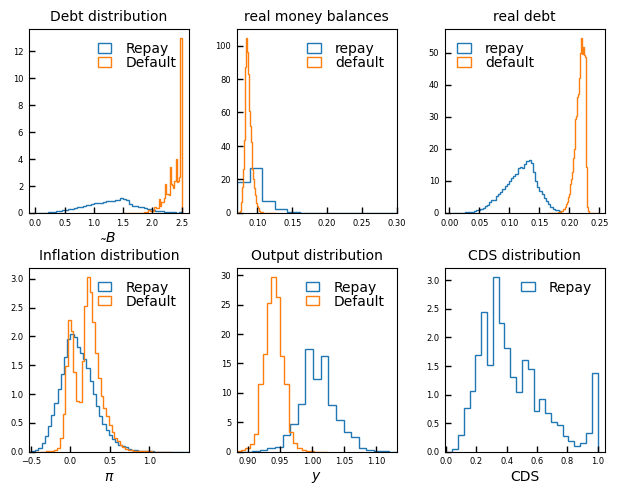

In [ ]:
fn = 1
figure(fn)
clf()
fig, axs = subplots(2, 3, num=fn, clear=true)

sca(axs[1]); title("Debt distribution")
hist(sa.B_sim[repind], bins=50, density=true, histtype="step", label="Repay")
hist(sa.B_sim[defind], bins=50, density=true, histtype="step", label="Default")
xlabel(L"\tilde B")

sca(axs[3]); title("real money balances")
hist(sa.rb_sim[repind], bins=25, density=true, histtype="step", label="repay")
hist(sa.rb_sim[defind], bins=50, density=true, histtype="step", label="default")
xlim(minimum(sa.rb_sim[time_ind]), 0.3)

sca(axs[5]); title("real debt")
hist(sa.B_sim[repind].*sa.rb_sim[repind]./sa.y_sim[repind], bins=50, density=true, histtype="step", label="repay")
hist(sa.B_sim[defind].*sa.rb_sim[defind]./sa.y_sim[defind], bins=50, density=true, histtype="step", label="default")

sca(axs[2]); title("Inflation distribution")
hist(sa.inf_yoy_sim[repind], bins=50, density=true, histtype="step", label="Repay")
hist(sa.inf_yoy_sim[defind], bins=50, density=true, histtype="step", label="Default")
xlabel(L"\pi")
xlim(minimum(sa.inf_yoy_sim[time_ind]), maximum(sa.inf_yoy_sim[time_ind]))

sca(axs[4]); title("Output distribution")
hist(sa.y_sim[repind], bins=21, density=true, histtype="step", label="Repay")
hist(sa.y_sim[defind], bins=21, density=true, histtype="step", label="Default")
xlabel(L"y")
xlim(minimum(sa.y_sim[time_ind]), maximum(sa.y_sim[time_ind]))

sca(axs[6]); title("CDS distribution")
hist(sp.expdef_long_sim[repind], bins=25, density=true, histtype="step", label="Repay")
xlabel("CDS")

plot_style(fn, title_coords=(0.5,1))
subplots_adjust(left=0.05, right=0.95, top=0.94, bottom=0.06, wspace=0.3, hspace=0.3)

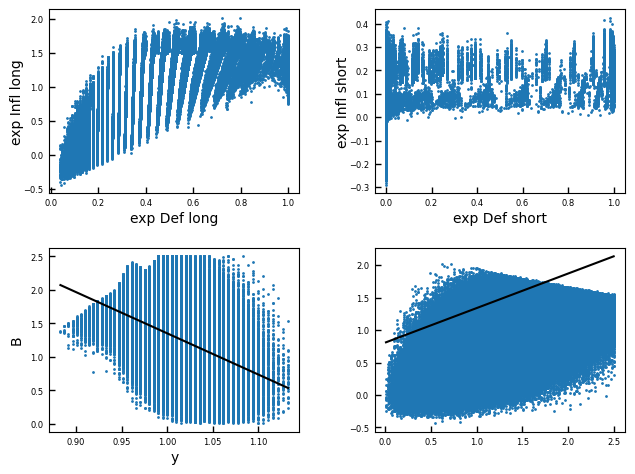

In [ ]:
CUDA.allowscalar(true)

fn = 1
figure(fn)
clf()
fig, axs = subplots(2, 2, num=fn, clear=true)

df = DataFrame(y=Vector{Float64}(sa.y_sim[repind]), B=Vector{Float64}(sa.B_sim[repind]), cds_long=Vector{Float64}(sp.expdef_long_sim[repind]), xcs_long=Vector{Float64}(sp.expinf_long_sim[repind]))

sca(axs[1])
plot(sp.expdef_long_sim[repind], sp.expinf_long_sim[repind], "o", ms=1)
xlabel("exp Def long")
ylabel("exp Infl long")

sca(axs[2])
plot(sa.y_sim[repind], sa.B_sim[repind], "o", ms=1)
betacoeffs = coef(lm(@formula(B ~ y), df))
plot(ma.ygrid, betacoeffs[1].+betacoeffs[2].*ma.ygrid, "-k")
xlabel("y")
ylabel("B")

sca(axs[3])
plot(sp.expdef_short_sim[repind], sp.expinf_short_sim[repind], "o", ms=1)
xlabel("exp Def short")
ylabel("exp Infl short")

sca(axs[4])
plot(sa.B_sim[repind], sp.expinf_long_sim[repind], "o", ms=1)
betacoeffs = coef(lm(@formula(B ~ xcs_long), df))
plot(ma.Bgrid, betacoeffs[1].+betacoeffs[2].*ma.Bgrid, "-k")


plot_style(fn, title_coords=(0.5,1))
subplots_adjust(left=0.05, right=0.95, top=0.94, bottom=0.06, wspace=0.3, hspace=0.3)

In [ ]:
betas = coef(lm(@formula(B ~ xcs_long), df))
betas[1].+betas[2].*ma.Bgrid

151-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 0.8112171186753073
 0.8200386995465657
 0.828860281407672
 0.8376818612890825
 0.8465034411704929
 0.855325025011295
 0.8641466048927054
 0.8729681887335076
 0.8817897686149181
 0.8906113484963285
 0.899432928377739
 0.9082545082591496
 0.91707608814056
 ⋮
 2.037416867699005
 2.046238518849464
 2.0550600432993926
 2.0638815677493207
 2.07270321889978
 2.081524743349708
 2.090346394500167
 2.0991679189500956
 2.107989570100554
 2.1168110945504828
 2.125632745700942
 2.13445427015087